In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

In [48]:
def load_and_process_eeg_data():
    """Load EEG data and extract neural features - CORRECTED VERSION"""
    
    # Load the dataset
    try:
        eeg_df = pd.read_csv('Data/combined_eeg_data.csv')
        print(f"✓ Loaded {len(eeg_df):,} EEG measurements")
        print(f"✓ Participants: {eeg_df['participant'].nunique()}")
        print(f"✓ Electrodes: {eeg_df['electrode'].nunique()}")
        print(f"✓ Frequencies: {eeg_df['frequency'].nunique()}")
        print(f"✓ Conditions: {list(eeg_df['condition'].unique())}")
    except FileNotFoundError:
        print("❌ Error: combined_eeg_data.csv not found")
        return None
    
    # Process complex coefficients
    def process_complex_coeff(coeff_str):
        """Extract magnitude and phase from complex coefficients"""
        try:
            if pd.isna(coeff_str):
                return np.nan, np.nan
            # Convert 'i' to 'j' for Python complex numbers
            coeff_str = str(coeff_str).strip('()')
            if 'i' in coeff_str and 'j' not in coeff_str:
                coeff_str = coeff_str.replace('i', 'j')
            coeff = complex(coeff_str)
            return abs(coeff), np.angle(coeff)  # magnitude and phase
        except:
            return np.nan, np.nan
    
    # Extract magnitude (neural activity strength) and phase
    complex_processed = eeg_df['coeff'].apply(process_complex_coeff)
    eeg_df['magnitude'] = [x[0] for x in complex_processed]
    eeg_df['phase'] = [x[1] for x in complex_processed]
    
    # Remove invalid data
    initial_rows = len(eeg_df)
    eeg_df = eeg_df.dropna(subset=['magnitude', 'phase'])
    print(f"✓ Processed complex coefficients")
    print(f"✓ Removed {initial_rows - len(eeg_df):,} invalid measurements")
    print(f"✓ Clean dataset: {len(eeg_df):,} measurements")
    
    return eeg_df

# Load and process data
eeg_df = load_and_process_eeg_data()

✓ Loaded 3,118,080 EEG measurements
✓ Participants: 14
✓ Electrodes: 32
✓ Frequencies: 58
✓ Conditions: ['GN', 'GS', 'UN', 'US']
✓ Processed complex coefficients
✓ Removed 0 invalid measurements
✓ Clean dataset: 3,118,080 measurements


In [50]:
def create_feature_matrix(eeg_df):
    """Create feature matrix for LDA analysis - CORRECTED VERSION"""
    
    # Create electrode-frequency feature combinations with proper naming
    eeg_df['electrode_freq'] = (
        eeg_df['electrode'].astype(str) + '_' + 
        eeg_df['frequency'].round(6).astype(str) + 'Hz'  # Round to avoid precision issues
    )
    
    print(f"✓ Sample electrode-frequency combinations:")
    sample_combos = eeg_df['electrode_freq'].unique()[:10]
    for combo in sample_combos:
        print(f"    {combo}")
    
    # Create pivot table: trials × electrode-frequency features
    # Use magnitude as it represents general brain response strength
    feature_matrix = eeg_df.pivot_table(
        index=['participant', 'trial', 'condition'],
        columns='electrode_freq',
        values='magnitude',  # Focus on neural activity strength
        aggfunc='mean'
    ).reset_index()
    
    # Get actual feature column names (exclude metadata columns)
    feature_cols = [col for col in feature_matrix.columns 
                   if col not in ['participant', 'trial', 'condition']]
    
    print(f"✓ Actual feature columns found: {len(feature_cols)}")
    print(f"✓ First 5 features: {feature_cols[:5]}")
    print(f"✓ Last 5 features: {feature_cols[-5:]}")
    
    # Fill missing values with column means
    feature_matrix[feature_cols] = feature_matrix[feature_cols].fillna(
        feature_matrix[feature_cols].mean()
    )
    
    print(f"✓ Feature matrix created: {feature_matrix.shape}")
    print(f"✓ Neural features: {len(feature_cols)}")
    print(f"✓ Total trials: {len(feature_matrix)}")
    
    return feature_matrix, feature_cols

# Create feature matrix
if eeg_df is not None:
    feature_matrix, feature_cols = create_feature_matrix(eeg_df)


✓ Sample electrode-frequency combinations:
    C3_0.260417Hz
    C3_0.325521Hz
    C3_0.390625Hz
    C3_0.455729Hz
    C3_0.520833Hz
    C3_0.585938Hz
    C3_0.651042Hz
    C3_0.716146Hz
    C3_0.78125Hz
    C3_0.846354Hz
✓ Actual feature columns found: 1856
✓ First 5 features: ['C3_0.260417Hz', 'C3_0.325521Hz', 'C3_0.390625Hz', 'C3_0.455729Hz', 'C3_0.520833Hz']
✓ Last 5 features: ['TP9_3.710938Hz', 'TP9_3.776042Hz', 'TP9_3.841146Hz', 'TP9_3.90625Hz', 'TP9_3.971354Hz']
✓ Feature matrix created: (1680, 1859)
✓ Neural features: 1856
✓ Total trials: 1680


In [62]:
def apply_lda_components(feature_matrix, feature_cols):
    """Apply LDA to find discriminant components for optimal condition separation"""
    
    print(f"\n🔄 APPLYING LDA FOR CONDITION DISCRIMINATION")
    print("-" * 45)
    
    # Prepare data
    X = feature_matrix[feature_cols].values
    y = feature_matrix['condition'].values
    
    # LDA can find at most min(n_features, n_classes-1) components
    n_classes = len(np.unique(y))
    max_components = min(X.shape[1], n_classes - 1)
    n_components = min(3, max_components)  # Use 3 or maximum possible
    
    print(f"Original dimensionality: {X.shape[1]} features → {n_components} discriminant components")
    print(f"Number of conditions: {n_classes}")
    print(f"Maximum possible components: {max_components}")
    print(f"Using {n_components} components for analysis")
    
    # Standardize features (recommended for LDA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✓ Features standardized")
    
    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X_scaled, y)
    
    # Calculate explained variance ratio (proportion of between-class variance)
    explained_var_ratio = lda.explained_variance_ratio_
    total_explained_var = explained_var_ratio.sum()
    cumulative_var = np.cumsum(explained_var_ratio)
    
    print(f"✓ LDA transformation complete")
    for i in range(n_components):
        print(f"  LD{i+1}: {explained_var_ratio[i]:.1%} discriminative power")
    print(f"  Total discriminative variance captured: {total_explained_var:.1%}")
    
    # Store results
    results = {
        'model': lda,
        'data': X_lda,
        'scaler': scaler,
        'explained_variance_ratio': explained_var_ratio,
        'total_explained_variance': total_explained_var,
        'cumulative_variance': cumulative_var,
        'original_features': X.shape[1],
        'n_components': n_components
    }
    
    return results, X, y

# Apply LDA
if 'feature_matrix' in locals():
    lda_results, X_original, y_conditions = apply_lda_components(feature_matrix, feature_cols)


🔄 APPLYING LDA FOR CONDITION DISCRIMINATION
---------------------------------------------
Original dimensionality: 1856 features → 3 discriminant components
Number of conditions: 4
Maximum possible components: 3
Using 3 components for analysis
✓ Features standardized
✓ LDA transformation complete
  LD1: 36.4% discriminative power
  LD2: 34.2% discriminative power
  LD3: 29.4% discriminative power
  Total discriminative variance captured: 100.0%


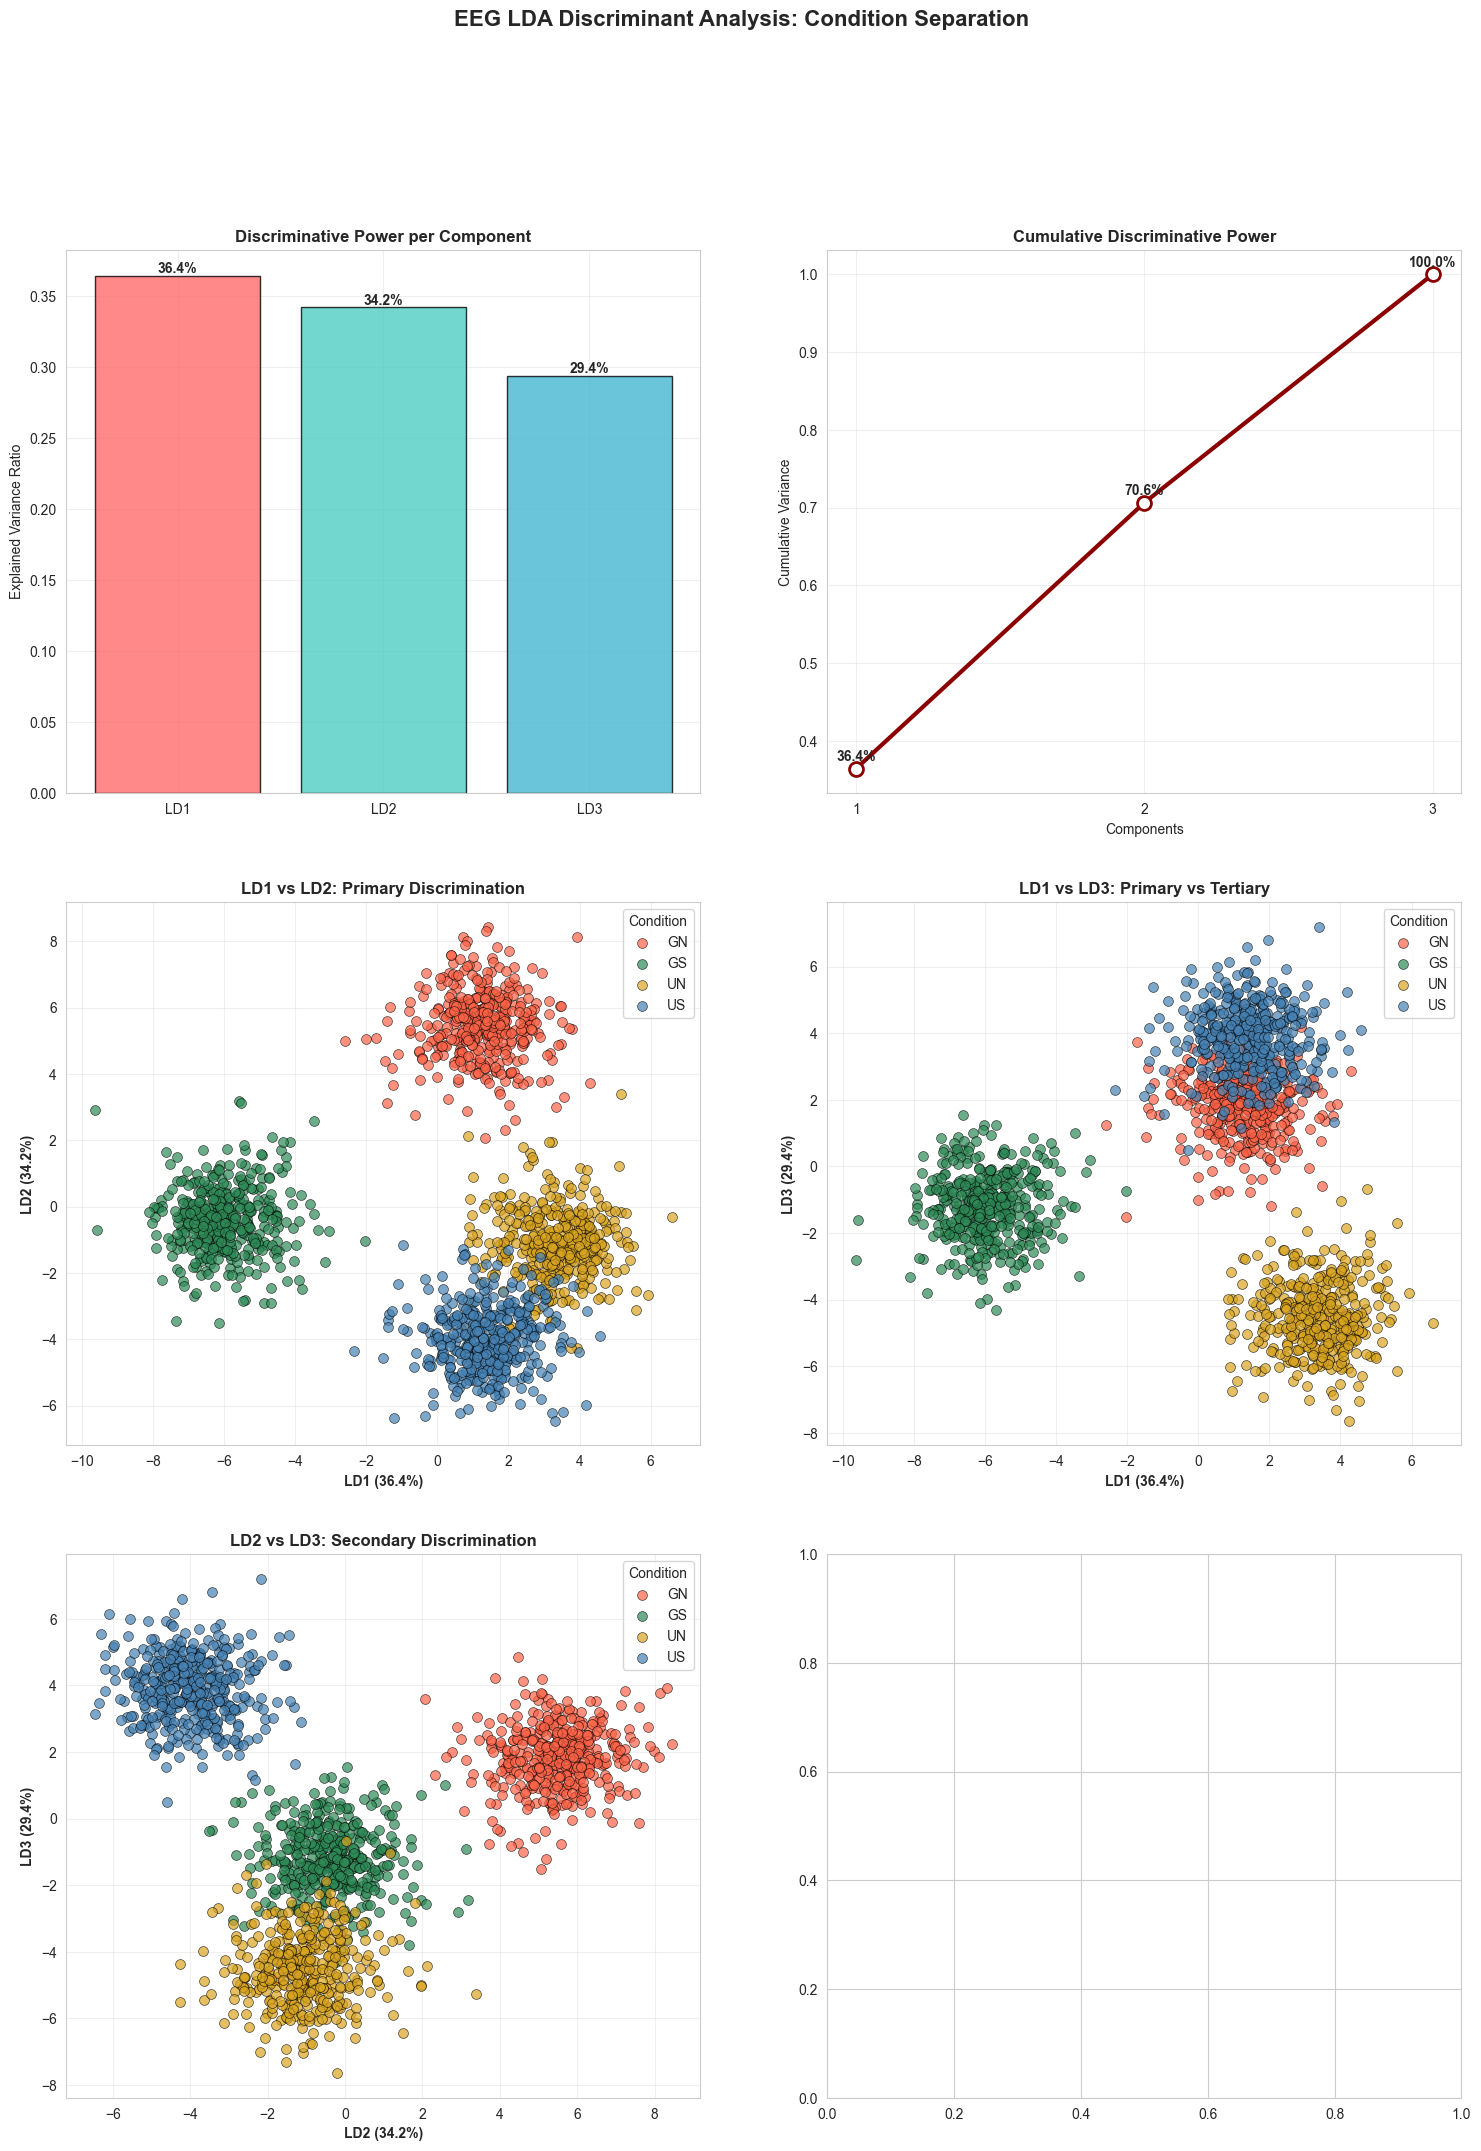

In [63]:
def visualize_lda_components(results, y_conditions):
    """Create comprehensive visualization of LDA results"""
    
    # Color mapping for conditions  
    colors = {'GS': '#2E8B57', 'GN': '#FF6347', 'US': '#4682B4', 'UN': '#DAA520'}
    condition_names = {'GS': 'Grammatical Sensible', 'GN': 'Grammatical Nonsense', 
                      'US': 'Ungrammatical Sensible', 'UN': 'Ungrammatical Nonsense'}
    
    X_lda = results['data']
    explained_var = results['explained_variance_ratio']
    n_components = results['n_components']
    
    # Create visualization - adjust layout based on number of components
    if n_components == 3:
        fig, axes = plt.subplots(3, 2, figsize=(18, 24))


    fig.suptitle('EEG LDA Discriminant Analysis: Condition Separation', fontsize=16, fontweight='bold')
    
    # 1. Explained Variance by Component
    ax = axes[0, 0]
    comp_labels = [f'LD{i+1}' for i in range(n_components)]
    bars = ax.bar(comp_labels, explained_var, 
                  color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:n_components], 
                  alpha=0.8, edgecolor='black')
    ax.set_title('Discriminative Power per Component', fontweight='bold')
    ax.set_ylabel('Explained Variance Ratio')
    ax.grid(True, alpha=0.3)
    
    for bar, var in zip(bars, explained_var):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{var:.1%}', ha='center', fontweight='bold')
    
    # 2. Cumulative Variance
    ax = axes[0, 1]
    cumulative_var = results['cumulative_variance']
    ax.plot(range(1, n_components+1), cumulative_var, 'o-', linewidth=3, markersize=10, 
            color='darkred', markerfacecolor='white', markeredgewidth=2)
    ax.set_title('Cumulative Discriminative Power', fontweight='bold')
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative Variance')
    ax.set_xticks(range(1, n_components+1))
    ax.grid(True, alpha=0.3)
    
    for i, var in enumerate(cumulative_var):
        ax.text(i+1, var + 0.01, f'{var:.1%}', ha='center', fontweight='bold')
    

    
    # Scatter plots for component pairs
    if n_components >= 2:
        # LD1 vs LD2
        ax = axes[1, 0]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD1 ({explained_var[0]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD2 ({explained_var[1]:.1%})', fontweight='bold')
        ax.set_title('LD1 vs LD2: Primary Discrimination', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)
    
    if n_components == 3:
        # LD1 vs LD3
        ax = axes[1, 1]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 0], X_lda[mask, 2], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD1 ({explained_var[0]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD3 ({explained_var[2]:.1%})', fontweight='bold')
        ax.set_title('LD1 vs LD3: Primary vs Tertiary', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)
        
        # LD2 vs LD3
        ax = axes[2, 0]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 1], X_lda[mask, 2], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD2 ({explained_var[1]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD3 ({explained_var[2]:.1%})', fontweight='bold')
        ax.set_title('LD2 vs LD3: Secondary Discrimination', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)


# Create visualizations
if 'lda_results' in locals():
    visualize_lda_components(lda_results, y_conditions)

In [64]:
def analyze_component_features(results, feature_cols):
    """Analyze which features contribute most to each discriminant component"""
    
    print(f"\n🔬 DISCRIMINANT COMPONENT FEATURE ANALYSIS")
    print("-" * 45)
    
    # Get discriminant function coefficients (scalings)
    scalings = results['model'].scalings_
    n_components = results['n_components']
    
    print(f"Debug info:")
    print(f"  Scalings shape: {scalings.shape}")
    print(f"  Number of feature_cols: {len(feature_cols)}")
    print(f"  Number of components: {n_components}")
    
    # Check if dimensions match
    if scalings.shape[0] != len(feature_cols):
        print(f"⚠️  Dimension mismatch detected!")
        print(f"   Scalings has {scalings.shape[0]} features")
        print(f"   feature_cols has {len(feature_cols)} features")
        
        # Use the minimum length to avoid errors
        min_length = min(scalings.shape[0], len(feature_cols))
        feature_cols_matched = feature_cols[:min_length]
        scalings_matched = scalings[:min_length, :]
        
        print(f"   Using first {min_length} features for analysis")
    else:
        feature_cols_matched = feature_cols
        scalings_matched = scalings
    
    for i in range(n_components):
        print(f"\n--- LD{i+1} ({results['explained_variance_ratio'][i]:.1%} discriminative power) ---")
        
        # Get feature loadings (discriminant coefficients)
        loadings = scalings_matched[:, i]
        
        # Ensure arrays have same length
        if len(feature_cols_matched) != len(loadings):
            print(f"   Error: Still have length mismatch after correction")
            print(f"   feature_cols_matched: {len(feature_cols_matched)}")
            print(f"   loadings: {len(loadings)}")
            continue
            
        feature_importance = pd.DataFrame({
            'feature': feature_cols_matched,
            'loading': loadings,
            'abs_loading': np.abs(loadings)
        }).sort_values('abs_loading', ascending=False)
        
        # Show top 8 contributing features
        print("Top discriminating electrode-frequency combinations:")
        for j, (_, row) in enumerate(feature_importance.head(8).iterrows()):
            try:
                electrode, freq = row['feature'].split('_')
                freq = freq.replace('Hz', '')
                print(f"  {j+1}. {electrode:4s} @ {freq:>6s}Hz  (coefficient: {row['loading']:+.3f})")
            except ValueError:
                # Handle case where split doesn't work as expected
                print(f"  {j+1}. {row['feature']:15s}  (coefficient: {row['loading']:+.3f})")
    
    return scalings_matched

# Analyze components with error handling
if 'lda_results' in locals() and 'feature_cols' in locals():
    try:
        discriminant_coefficients = analyze_component_features(lda_results, feature_cols)
    except Exception as e:
        print(f"Error in component analysis: {e}")
        print("Checking data dimensions...")
        print(f"LDA model scalings shape: {lda_results['model'].scalings_.shape}")
        print(f"Feature columns length: {len(feature_cols)}")
        print(f"First few feature names: {feature_cols[:5]}")
else:
    print("Required variables not found. Please run LDA analysis first.")


🔬 DISCRIMINANT COMPONENT FEATURE ANALYSIS
---------------------------------------------
Debug info:
  Scalings shape: (1856, 3)
  Number of feature_cols: 1856
  Number of components: 3

--- LD1 (36.4% discriminative power) ---
Top discriminating electrode-frequency combinations:
  1. PO10 @  3.125Hz  (coefficient: +5.806)
  2. FC6  @ 2.473958Hz  (coefficient: -5.353)
  3. T8   @ 2.408854Hz  (coefficient: -4.894)
  4. T8   @  3.125Hz  (coefficient: +4.404)
  5. FC1  @ 1.692708Hz  (coefficient: +4.189)
  6. O2   @ 2.864583Hz  (coefficient: +3.955)
  7. O2   @ 3.190104Hz  (coefficient: +3.883)
  8. FC1  @ 1.432292Hz  (coefficient: +3.820)

--- LD2 (34.2% discriminative power) ---
Top discriminating electrode-frequency combinations:
  1. PO10 @ 3.320312Hz  (coefficient: -4.782)
  2. Cz   @ 2.929688Hz  (coefficient: -4.544)
  3. Oz   @ 2.669271Hz  (coefficient: -4.430)
  4. CP2  @ 3.710938Hz  (coefficient: +4.327)
  5. O1   @ 0.78125Hz  (coefficient: -4.046)
  6. PO10 @ 2.34375Hz  (coeffic

In [65]:
def analyze_actual_electrodes_and_create_lda_maps(results, feature_cols, eeg_df):
    """Analyze actual electrodes and create topographic visualizations for LDA discriminant patterns"""
    
    print(f"\n🔍 EEG LDA TOPOGRAPHIC MAPPING - DISCRIMINANT PATTERN ANALYSIS")
    print("-" * 75)
    
    # Extract actual electrodes from your data
    actual_electrodes = sorted(set(feature.split('_')[0] for feature in feature_cols))
    
    print(f"✓ Found {len(actual_electrodes)} electrodes in your data:")
    print(f"  {actual_electrodes}")
    
    # Comprehensive 10-20 system reference (with precise anatomical positions)
    electrode_positions = {
        # Frontal Region
        'Fp1': (-0.35, 0.85), 'Fp2': (0.35, 0.85), 
        'F7': (-0.75, 0.55), 'F3': (-0.4, 0.6), 'Fz': (0.0, 0.65), 'F4': (0.4, 0.6), 'F8': (0.75, 0.55),
        
        # Fronto-Central Region
        'FC5': (-0.6, 0.35), 'FC1': (-0.2, 0.4), 'FC2': (0.2, 0.4), 'FC6': (0.6, 0.35),
        
        # Central Region
        'T7': (-0.85, 0.0), 'C3': (-0.4, 0.0), 'Cz': (0.0, 0.0), 'C4': (0.4, 0.0), 'T8': (0.85, 0.0),
        
        # Central-Parietal Region
        'CP5': (-0.6, -0.35), 'CP1': (-0.2, -0.4), 'CP2': (0.2, -0.4), 'CP6': (0.6, -0.35),
        
        # Parietal Region
        'P7': (-0.75, -0.55), 'P3': (-0.4, -0.6), 'Pz': (0.0, -0.65), 'P4': (0.4, -0.6), 'P8': (0.75, -0.55),
        
        # Parieto-Occipital Region
        'PO9': (-0.75, -0.75), 'PO10': (0.75, -0.75),
        
        # Temporal-Parietal Region
        'TP9': (-0.9, -0.3), 'TP10': (0.9, -0.3),
        
        # Occipital Region
        'O1': (-0.35, -0.85), 'Oz': (0.0, -0.9), 'O2': (0.35, -0.85)
    }
    
    # Verify all your electrodes have positions defined
    missing = [e for e in actual_electrodes if e not in electrode_positions]
    if missing:
        print(f"❌ ERROR: {len(missing)} electrodes missing position definitions:")
        print(f"   {missing}")
        return None
    else:
        print(f"✓ All {len(actual_electrodes)} electrodes have anatomically accurate position definitions")
    
    # Calculate discriminant coefficients per electrode (averaged across frequencies)
    scalings = results['model'].scalings_
    n_components = results['n_components']
    electrode_coefficients = {}
    
    for ld_idx in range(n_components):
        electrode_coefficients[ld_idx] = {}
        for i, feature in enumerate(feature_cols):
            electrode = feature.split('_')[0]
            if electrode not in electrode_coefficients[ld_idx]:
                electrode_coefficients[ld_idx][electrode] = []
            electrode_coefficients[ld_idx][electrode].append(scalings[i, ld_idx])
        
        # Calculate mean coefficient per electrode
        for electrode in electrode_coefficients[ld_idx]:
            electrode_coefficients[ld_idx][electrode] = np.mean(electrode_coefficients[ld_idx][electrode])
    
    # Create visualizations
    print(f"\n🎨 GENERATING DISCRIMINANT PATTERN TOPOGRAPHIC MAPS")
    print("-" * 55)
    
    # Determine global color scale for consistent visualization across components
    all_coefficients = []
    for ld_idx in range(n_components):
        all_coefficients.extend(electrode_coefficients[ld_idx].values())
    
    global_vmax = max(abs(min(all_coefficients)), abs(max(all_coefficients)))
    global_vmax = global_vmax * 1.05  # Add 5% padding
    
    # Define regions based on electrode positions
    frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8']
    central = ['FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8']
    parietal = ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'TP9', 'TP10']
    occipital = ['PO9', 'PO10', 'O1', 'Oz', 'O2']
    
    # Create separate topographic maps for each discriminant component
    for ld_idx in range(n_components):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Prepare data
        x_coords = []
        y_coords = []
        coefficients = []
        labels = []
        
        for electrode in actual_electrodes:
            x, y = electrode_positions[electrode]
            x_coords.append(x)
            y_coords.append(y)
            coefficients.append(electrode_coefficients[ld_idx][electrode])
            labels.append(electrode)
        
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)
        coefficients = np.array(coefficients)
        
        # Create higher resolution grid for smoother interpolation
        resolution = 100
        xi = np.linspace(-1.1, 1.1, resolution)
        yi = np.linspace(-1.1, 1.1, resolution)
        Xi, Yi = np.meshgrid(xi, yi)
        
        # Create anatomically accurate head mask
        mask = (Xi**2/0.9 + Yi**2) <= 1.15 
        
        # Interpolate using robust method
        from scipy.interpolate import RBFInterpolator
        try:
            interpolator = RBFInterpolator(
                np.column_stack((x_coords, y_coords)), 
                coefficients,
                kernel='thin_plate_spline',
                epsilon=0.1
            )
            Zi = interpolator(np.column_stack((Xi.flatten(), Yi.flatten())))
            Zi = Zi.reshape(Xi.shape)
        except:
            # Fallback to griddata
            from scipy.interpolate import griddata
            Zi = griddata((x_coords, y_coords), coefficients, (Xi, Yi), 
                         method='cubic', fill_value=0)
        
        # Apply head mask
        Zi[~mask] = np.nan
        
        # Plot topographic map
        im = ax.contourf(Xi, Yi, Zi, levels=30, cmap='RdBu_r', 
                        vmin=-global_vmax, vmax=global_vmax, extend='both')
        
        # Add contour lines
        contours = ax.contour(Xi, Yi, Zi, levels=10, colors='k', linewidths=0.5, alpha=0.3,
                             vmin=-global_vmax, vmax=global_vmax)
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.2f')
        
        # Add electrode positions
        scatter = ax.scatter(x_coords, y_coords, c=coefficients, 
                           cmap='RdBu_r', s=120, edgecolors='k', 
                           linewidth=1.2, vmin=-global_vmax, vmax=global_vmax, zorder=5)
        
        # Smart electrode labeling
        for i, label in enumerate(labels):
            x, y = x_coords[i], y_coords[i]
            
            if label in ['Fp1', 'Fp2', 'O1', 'O2']:
                offset = (0, -15) if y < 0 else (0, 15)
            elif label in ['T7', 'T8', 'TP9', 'TP10']:
                offset = (-15, 0) if x < 0 else (15, 0)
            else:
                offset = (5, 5)
            
            ax.annotate(label, (x, y), xytext=offset, textcoords='offset points',
                       ha='center', va='center', fontsize=9, fontweight='bold',
                       color='k', bbox=dict(boxstyle='round,pad=0.2', 
                                           facecolor='white', alpha=0.85, edgecolor='gray'))
        
        # Draw head outline and features
        head = plt.Circle((0, 0), 1, fill=False, linewidth=2.5, color='k', alpha=0.9)
        ax.add_patch(head)
        
        # Nose
        ax.plot([0, 0], [1.0, 1.18], 'k-', linewidth=3.5)
        ax.plot([-0.08, 0.08], [1.12, 1.12], 'k-', linewidth=2.2)
        ax.plot([0, -0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        ax.plot([0, 0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        
        # Ears
        ear_l = plt.Polygon([(-1.05, 0.1), (-0.95, 0.15), (-0.9, 0.05), (-0.95, -0.05), (-1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ear_r = plt.Polygon([(1.05, 0.1), (0.95, 0.15), (0.9, 0.05), (0.95, -0.05), (1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ax.add_patch(ear_l)
        ax.add_patch(ear_r)
        
        # Grid lines
        for r in [0.25, 0.5, 0.75]:
            circle = plt.Circle((0, 0), r, fill=False, linestyle=':', 
                              color='gray', alpha=0.4, linewidth=1)
            ax.add_patch(circle)
        
        # Formatting
        variance_pct = results['explained_variance_ratio'][ld_idx]
        ax.set_title(f'LD{ld_idx+1} Discriminant Pattern\n({variance_pct:.1%} of Discriminative Power)', 
                    fontweight='bold', fontsize=14)
        ax.set_xlim(-1.35, 1.35)
        ax.set_ylim(-1.35, 1.35)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Discriminant Coefficient', fontsize=12, fontweight='bold')
        cbar.ax.axvline(x=0, color='k', linestyle='-', linewidth=1.2)
        
        plt.tight_layout()
        plt.show()
    
    # Create electrode contribution analysis
    fig, axes = plt.subplots(1, n_components, figsize=(6*n_components, 8))
    if n_components == 1:
        axes = [axes]
        
    fig.suptitle('EEG LDA Analysis: Electrode Discriminant Contributions', 
                 fontsize=16, fontweight='bold')
    
    # Region colors for shading
    region_colors = {
        'Frontal': (0.9, 0.95, 1.0, 0.3),
        'Central': (0.95, 0.95, 0.95, 0.3),
        'Parietal': (0.9, 1.0, 0.9, 0.3),
        'Occipital': (1.0, 0.9, 0.9, 0.3)
    }
    
    for ld_idx in range(n_components):
        ax = axes[ld_idx]
        
        # Get sorted electrodes by absolute coefficient
        sorted_electrodes = sorted(electrode_coefficients[ld_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        
        electrodes = [item[0] for item in sorted_electrodes]
        coeffs = [item[1] for item in sorted_electrodes]
        
        # Create diverging color map
        colors = []
        for coeff in coeffs:
            if coeff < 0:
                intensity = min(1.0, abs(coeff)/global_vmax)
                colors.append((1.0, 1.0-intensity*0.7, 1.0-intensity*0.7))
            else:
                intensity = min(1.0, abs(coeff)/global_vmax)
                colors.append((1.0-intensity*0.7, 1.0-intensity*0.7, 1.0))
        
        # Create horizontal bar chart
        y_pos = np.arange(len(electrodes))
        bars = ax.barh(y_pos, coeffs, color=colors, edgecolor='k', linewidth=0.7)
        
        # Add value labels
        for i, v in enumerate(coeffs):
            if abs(v) > global_vmax * 0.1:
                ax.text(v + (0.05 * np.sign(v) * global_vmax), i, f'{v:.3f}', 
                       va='center', ha='left' if v > 0 else 'right', fontsize=8)
        
        # Add region shading
        for i, electrode in enumerate(electrodes):
            if electrode in frontal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Frontal'], alpha=0.6)
            elif electrode in central:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Central'], alpha=0.6)
            elif electrode in parietal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Parietal'], alpha=0.6)
            elif electrode in occipital:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Occipital'], alpha=0.6)
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels(electrodes)
        ax.set_xlabel('Discriminant Coefficient', fontweight='bold')
        variance_pct = results['explained_variance_ratio'][ld_idx]
        ax.set_title(f'LD{ld_idx+1} Electrode Contributions\n({variance_pct:.1%} Power)', 
                    fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.axvline(x=0, color='k', linestyle='-', linewidth=1.5)
        ax.set_xlim(-global_vmax*1.15, global_vmax*1.15)
        
        # Add region legend to first subplot
        if ld_idx == 0:
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor=region_colors['Frontal'], edgecolor='k', alpha=0.6, label='Frontal'),
                Patch(facecolor=region_colors['Central'], edgecolor='k', alpha=0.6, label='Central'),
                Patch(facecolor=region_colors['Parietal'], edgecolor='k', alpha=0.6, label='Parietal'),
                Patch(facecolor=region_colors['Occipital'], edgecolor='k', alpha=0.6, label='Occipital')
            ]
            ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
                     title="Cortical Regions", title_fontsize=10)
    
    plt.tight_layout()
    plt.savefig('eeg_lda_electrode_discriminant_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print(f"\n🧠 NEUROANATOMICAL INTERPRETATION OF DISCRIMINANT COMPONENTS")
    print("=" * 70)
    
    for ld_idx in range(n_components):
        print(f"\nLD{ld_idx+1} ({results['explained_variance_ratio'][ld_idx]:.1%} discriminative power):")
        
        # Identify dominant regions
        region_sums = {'Frontal': 0, 'Central': 0, 'Parietal': 0, 'Occipital': 0}
        region_counts = {k: 0 for k in region_sums}
        
        for electrode, coeff in electrode_coefficients[ld_idx].items():
            abs_coeff = abs(coeff)
            if electrode in frontal:
                region_sums['Frontal'] += abs_coeff
                region_counts['Frontal'] += 1
            elif electrode in central:
                region_sums['Central'] += abs_coeff
                region_counts['Central'] += 1
            elif electrode in parietal:
                region_sums['Parietal'] += abs_coeff
                region_counts['Parietal'] += 1
            elif electrode in occipital:
                region_sums['Occipital'] += abs_coeff
                region_counts['Occipital'] += 1
        
        # Calculate average coefficient per region
        region_averages = {k: region_sums[k]/region_counts[k] if region_counts[k] > 0 else 0 
                          for k in region_sums}
        
        dominant_region = max(region_averages, key=region_averages.get)
        
        # Determine pattern type
        polarity = "biphasic"
        if all(coeff >= 0 for coeff in electrode_coefficients[ld_idx].values()):
            polarity = "positive-dominant"
        elif all(coeff <= 0 for coeff in electrode_coefficients[ld_idx].values()):
            polarity = "negative-dominant"
        
        print(f"  Most discriminative region: {dominant_region}")
        print(f"  Pattern type: {polarity}")
        
        print(f"\n  Strongest discriminating electrodes:")
        sorted_electrodes = sorted(electrode_coefficients[ld_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        for i, (electrode, coeff) in enumerate(sorted_electrodes[:6]):
            region = ""
            if electrode in frontal: region = " (Frontal)"
            elif electrode in central: region = " (Central)"
            elif electrode in parietal: region = " (Parietal)"
            elif electrode in occipital: region = " (Occipital)"
                
            print(f"    {i+1:2d}. {electrode:6s}: {coeff:+.4f}{region}")
    
    return electrode_coefficients, actual_electrodes

# Analyze actual electrodes and create visualizations



🔍 EEG LDA TOPOGRAPHIC MAPPING - DISCRIMINANT PATTERN ANALYSIS
---------------------------------------------------------------------------
✓ Found 32 electrodes in your data:
  ['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'PO10', 'PO9', 'Pz', 'T7', 'T8', 'TP10', 'TP9']
✓ All 32 electrodes have anatomically accurate position definitions

🎨 GENERATING DISCRIMINANT PATTERN TOPOGRAPHIC MAPS
-------------------------------------------------------


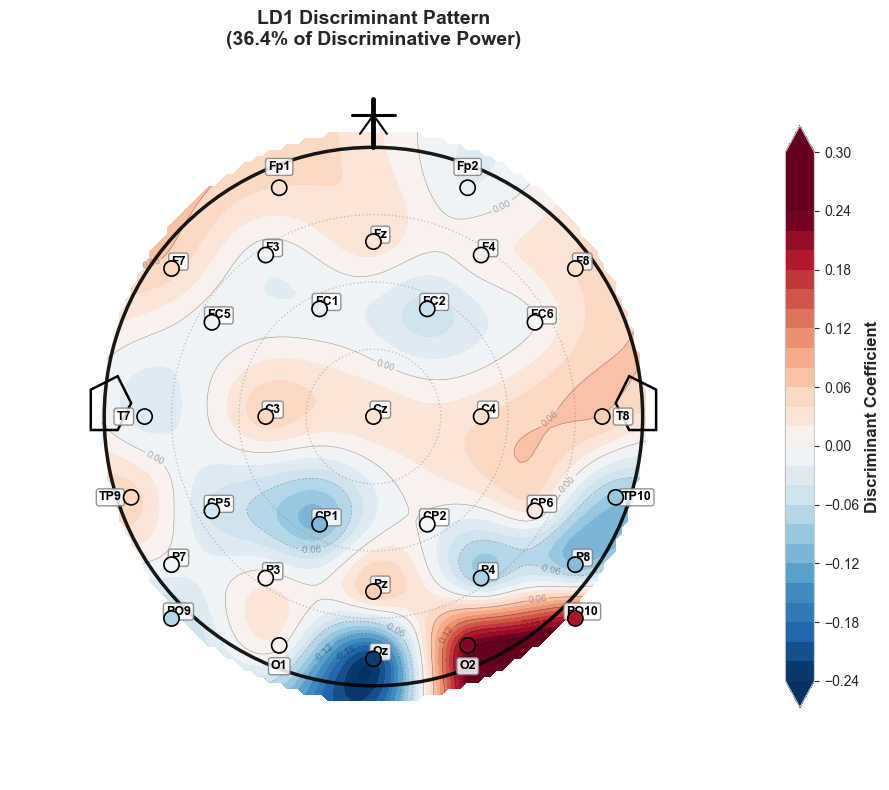

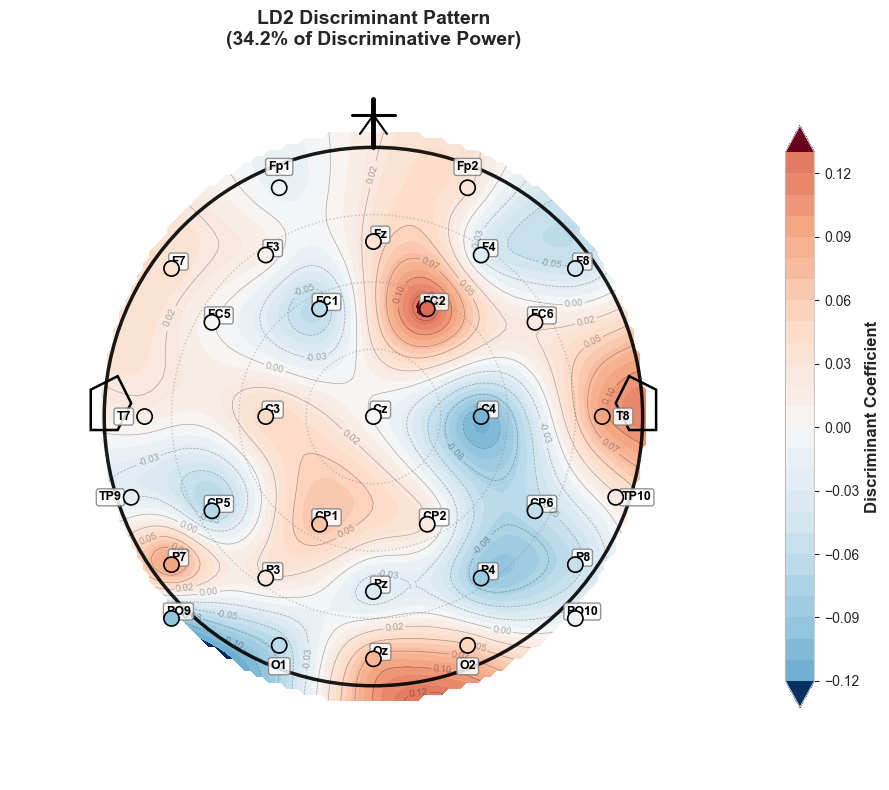

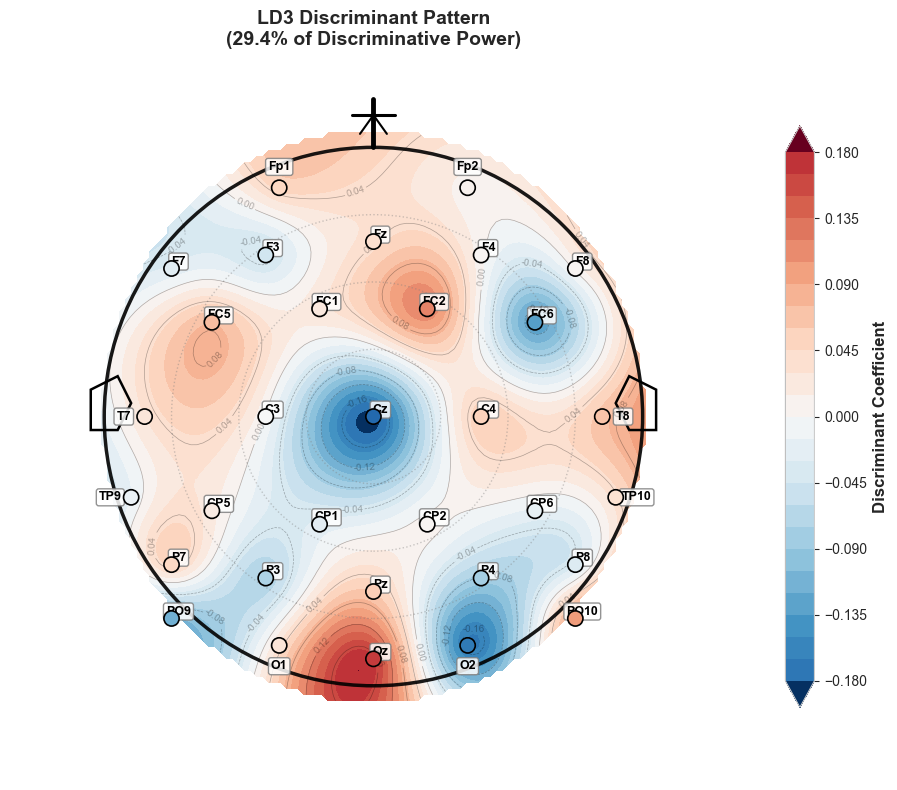

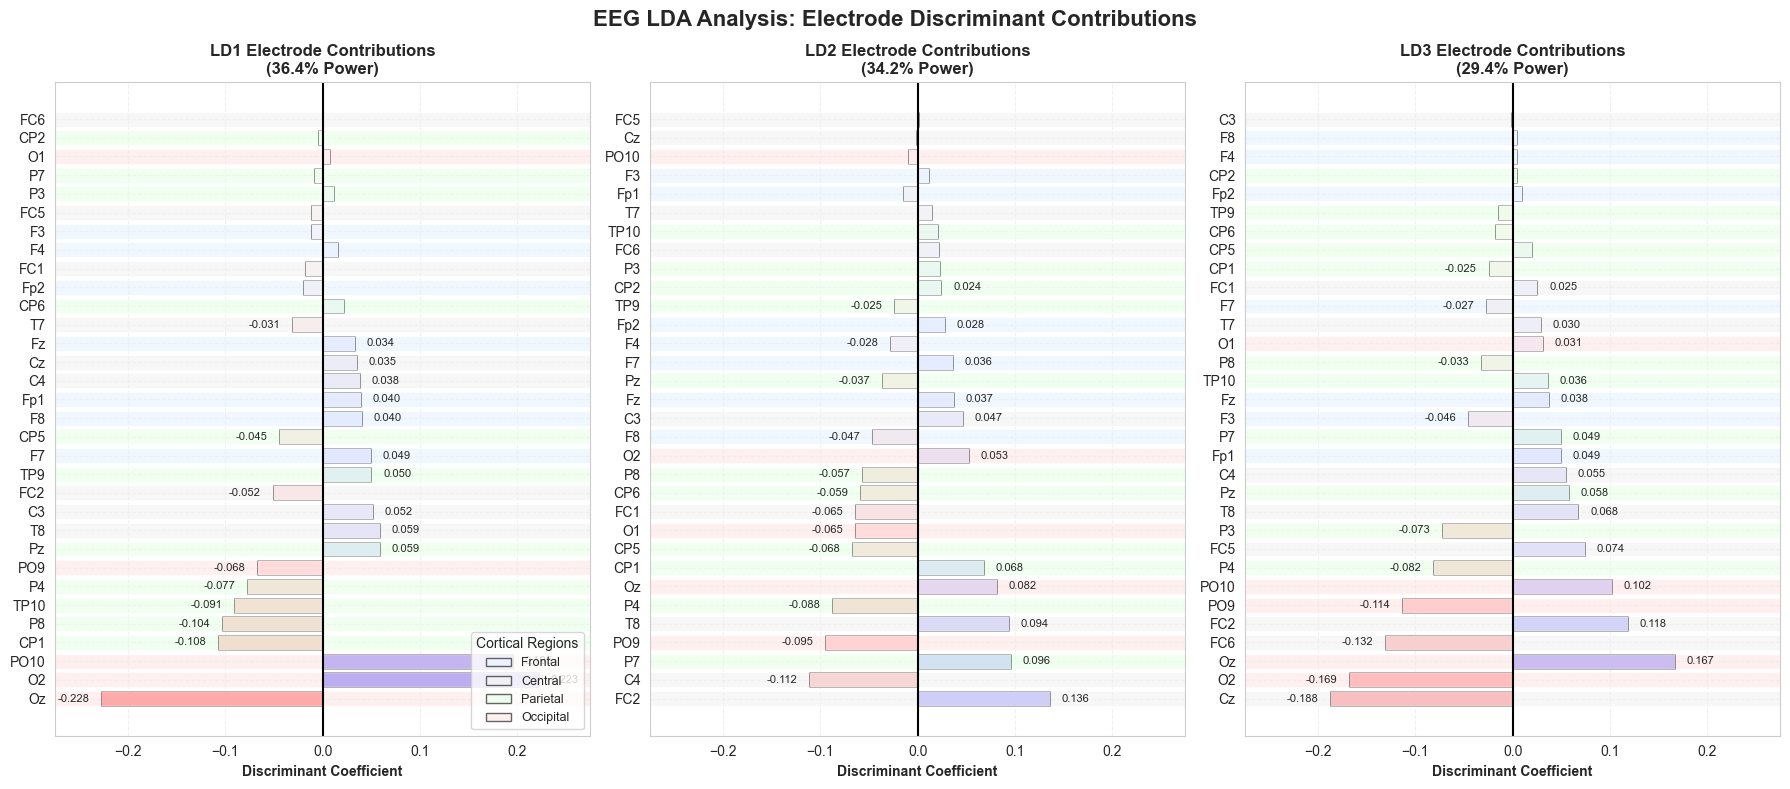


🧠 NEUROANATOMICAL INTERPRETATION OF DISCRIMINANT COMPONENTS

LD1 (36.4% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. Oz    : -0.2278 (Occipital)
     2. O2    : +0.2229 (Occipital)
     3. PO10  : +0.1955 (Occipital)
     4. CP1   : -0.1078 (Parietal)
     5. P8    : -0.1036 (Parietal)
     6. TP10  : -0.0911 (Parietal)

LD2 (34.2% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. FC2   : +0.1363 (Central)
     2. C4    : -0.1115 (Central)
     3. P7    : +0.0959 (Parietal)
     4. PO9   : -0.0949 (Occipital)
     5. T8    : +0.0942 (Central)
     6. P4    : -0.0877 (Parietal)

LD3 (29.4% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. Cz    : -0.1877 (Central)
     2. O2    : -0.1687 (Occipital)
     3. Oz    : +0.1672 (Occ

In [66]:

electrode_coefficients, actual_electrodes = analyze_actual_electrodes_and_create_lda_maps(
        lda_results, feature_cols, eeg_df)


🎯 DETAILED FREQUENCY-ELECTRODE LDA ANALYSIS
✓ Found 58 frequencies

==================== LD1 ANALYSIS ====================
Discriminative Power: 36.4%

Top 10 Discriminating Electrode-Frequency combinations:
   1. PO10 @    3.125Hz | Coefficient: +5.8064 | Importance: 5.8064
   2. FC6  @ 2.473958Hz | Coefficient: -5.3534 | Importance: 5.3534
   3. T8   @ 2.408854Hz | Coefficient: -4.8938 | Importance: 4.8938
   4. T8   @    3.125Hz | Coefficient: +4.4038 | Importance: 4.4038
   5. FC1  @ 1.692708Hz | Coefficient: +4.1888 | Importance: 4.1888
   6. O2   @ 2.864583Hz | Coefficient: +3.9550 | Importance: 3.9550
   7. O2   @ 3.190104Hz | Coefficient: +3.8834 | Importance: 3.8834
   8. FC1  @ 1.432292Hz | Coefficient: +3.8197 | Importance: 3.8197
   9. O2   @ 0.585938Hz | Coefficient: -3.7408 | Importance: 3.7408
  10. FC6  @ 0.325521Hz | Coefficient: +3.7244 | Importance: 3.7244

==================== LD2 ANALYSIS ====================
Discriminative Power: 34.2%

Top 10 Discriminating Elec

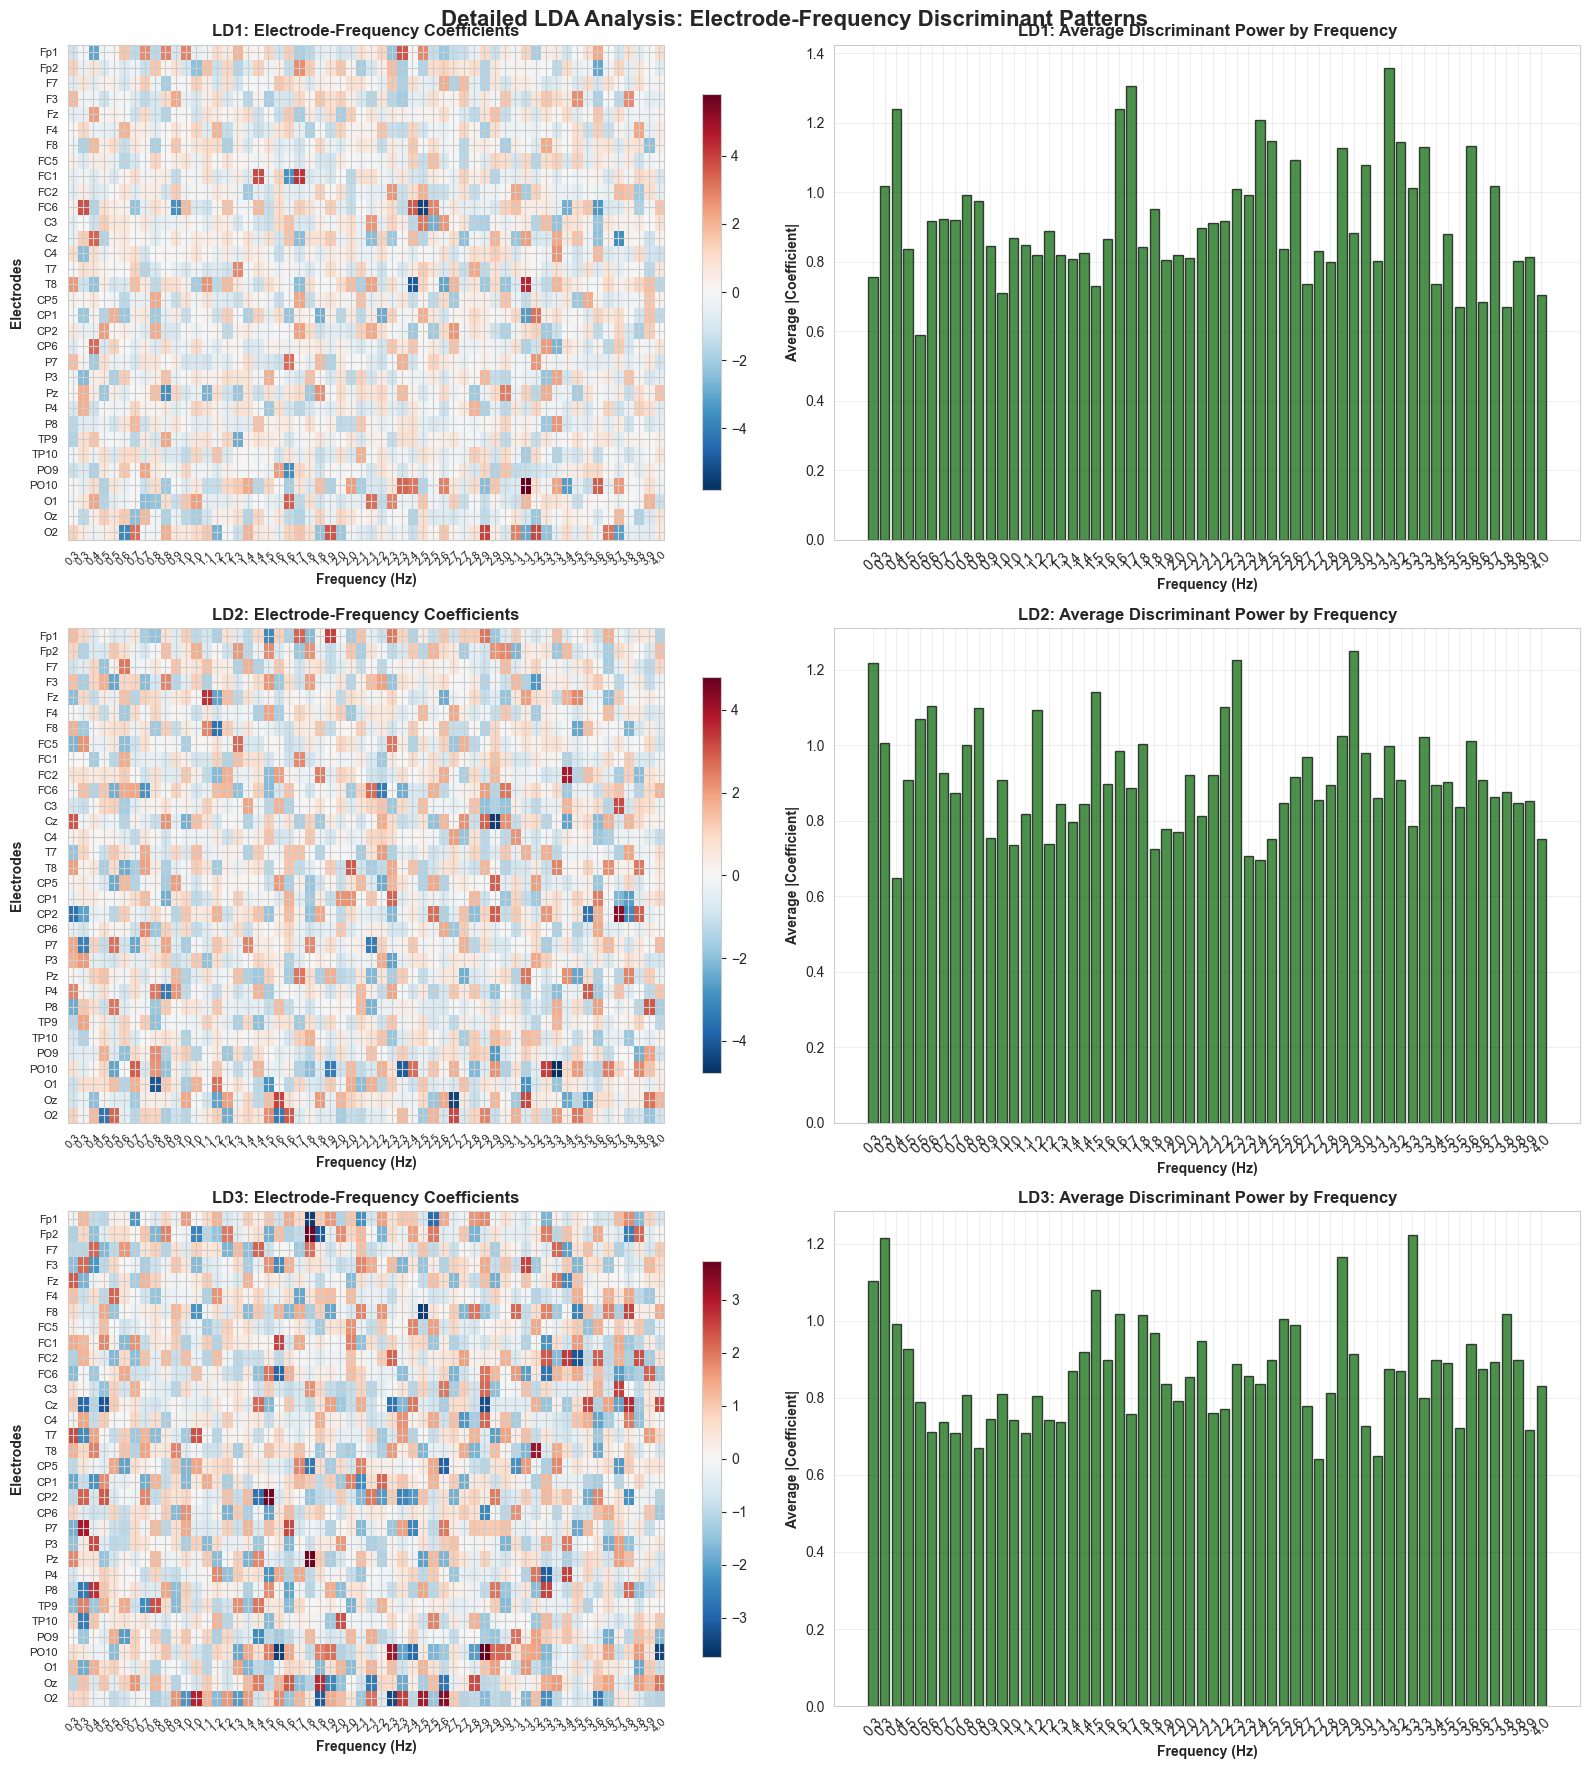

In [67]:
def analyze_frequency_electrode_lda_patterns(results, feature_cols):
    """Analyze electrode-frequency patterns for each discriminant component"""
    
    print(f"\n🎯 DETAILED FREQUENCY-ELECTRODE LDA ANALYSIS")
    print("=" * 55)
    
    scalings = results['model'].scalings_
    n_components = results['n_components']
    
    # Extract frequencies
    frequencies = set()
    for feature in feature_cols:
        freq_str = feature.split('_')[1].replace('Hz', '')
        try:
            freq = float(freq_str)
            frequencies.add(freq)
        except ValueError:
            continue
    
    frequencies = sorted(frequencies)
    print(f"✓ Found {len(frequencies)} frequencies")
    
    # Define brain regions
    brain_regions = {
        'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
        'Fronto-Central': ['FC5', 'FC1', 'FC2', 'FC6'],
        'Central': ['C3', 'Cz', 'C4'],
        'Temporal': ['T7', 'T8'],
        'Central-Parietal': ['CP5', 'CP1', 'CP2', 'CP6'],
        'Parietal': ['P7', 'P3', 'Pz', 'P4', 'P8'],
        'Temporal-Parietal': ['TP9', 'TP10'],
        'Parieto-Occipital': ['PO9', 'PO10'],
        'Occipital': ['O1', 'Oz', 'O2']
    }
    
    # Create analysis plots
    fig, axes = plt.subplots(n_components, 2, figsize=(16, 6*n_components))
    if n_components == 1:
        axes = axes.reshape(1, -1)
        
    fig.suptitle('Detailed LDA Analysis: Electrode-Frequency Discriminant Patterns', 
                 fontsize=16, fontweight='bold')
    
    for ld_idx in range(n_components):
        coefficients = scalings[:, ld_idx]
        
        print(f"\n{'='*20} LD{ld_idx+1} ANALYSIS {'='*20}")
        print(f"Discriminative Power: {results['explained_variance_ratio'][ld_idx]:.1%}")
        
        # Organize data by electrode and frequency
        electrode_freq_data = {}
        for i, feature in enumerate(feature_cols):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1].replace('Hz', '')
            try:
                freq = float(freq_str)
            except ValueError:
                continue
            
            if electrode not in electrode_freq_data:
                electrode_freq_data[electrode] = {}
            electrode_freq_data[electrode][freq] = coefficients[i]
        
        # Create heatmap
        ax_heatmap = axes[ld_idx, 0]
        
        all_electrodes = []
        for region_electrodes in brain_regions.values():
            all_electrodes.extend(region_electrodes)
        
        electrodes = [e for e in all_electrodes if e in electrode_freq_data]
        
        heatmap_data = []
        for electrode in electrodes:
            row = []
            for freq in frequencies:
                if freq in electrode_freq_data.get(electrode, {}):
                    row.append(electrode_freq_data[electrode][freq])
                else:
                    row.append(0)
            heatmap_data.append(row)
        
        heatmap_data = np.array(heatmap_data)
        
        if heatmap_data.size > 0:
            vmax = max(abs(heatmap_data.min()), abs(heatmap_data.max()))
            im = ax_heatmap.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', 
                                  vmin=-vmax, vmax=vmax)
            
            ax_heatmap.set_title(f'LD{ld_idx+1}: Electrode-Frequency Coefficients', 
                                fontweight='bold')
            ax_heatmap.set_xlabel('Frequency (Hz)', fontweight='bold')
            ax_heatmap.set_ylabel('Electrodes', fontweight='bold')
            ax_heatmap.set_xticks(range(len(frequencies)))
            freq_labels = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in frequencies]
            ax_heatmap.set_xticklabels(freq_labels, rotation=45, fontsize=8)
            ax_heatmap.set_yticks(range(len(electrodes)))
            ax_heatmap.set_yticklabels(electrodes, fontsize=8)
            
            plt.colorbar(im, ax=ax_heatmap, shrink=0.8)
        
        # Frequency analysis
        ax_freq = axes[ld_idx, 1]
        
        freq_coeffs = {}
        for freq in frequencies:
            freq_values = []
            for electrode in electrodes:
                if freq in electrode_freq_data.get(electrode, {}):
                    freq_values.append(abs(electrode_freq_data[electrode][freq]))
            if freq_values:
                freq_coeffs[freq] = np.mean(freq_values)
            else:
                freq_coeffs[freq] = 0
        
        freqs = list(freq_coeffs.keys())
        values = list(freq_coeffs.values())
        
        freq_labels_plot = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in freqs]
        
        bars = ax_freq.bar(range(len(freqs)), values, color='darkgreen', alpha=0.7, edgecolor='black')
        ax_freq.set_title(f'LD{ld_idx+1}: Average Discriminant Power by Frequency', fontweight='bold')
        ax_freq.set_xlabel('Frequency (Hz)', fontweight='bold')
        ax_freq.set_ylabel('Average |Coefficient|', fontweight='bold')
        ax_freq.set_xticks(range(len(freqs)))
        ax_freq.set_xticklabels(freq_labels_plot, rotation=45)
        ax_freq.grid(True, alpha=0.3)
        
        # Print detailed analysis
        print(f"\nTop 10 Discriminating Electrode-Frequency combinations:")
        feature_importance = [(feature_cols[i], abs(coefficients[i])) 
                            for i in range(len(feature_cols))]
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1]
            coeff_val = coefficients[feature_cols.index(feature)]
            print(f"  {i+1:2d}. {electrode:4s} @ {freq_str:>10s} | "
                  f"Coefficient: {coeff_val:+.4f} | Importance: {importance:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    return electrode_freq_data


lda_detailed_analysis = analyze_frequency_electrode_lda_patterns(lda_results, feature_cols)


Plotting LDA discriminant scores...


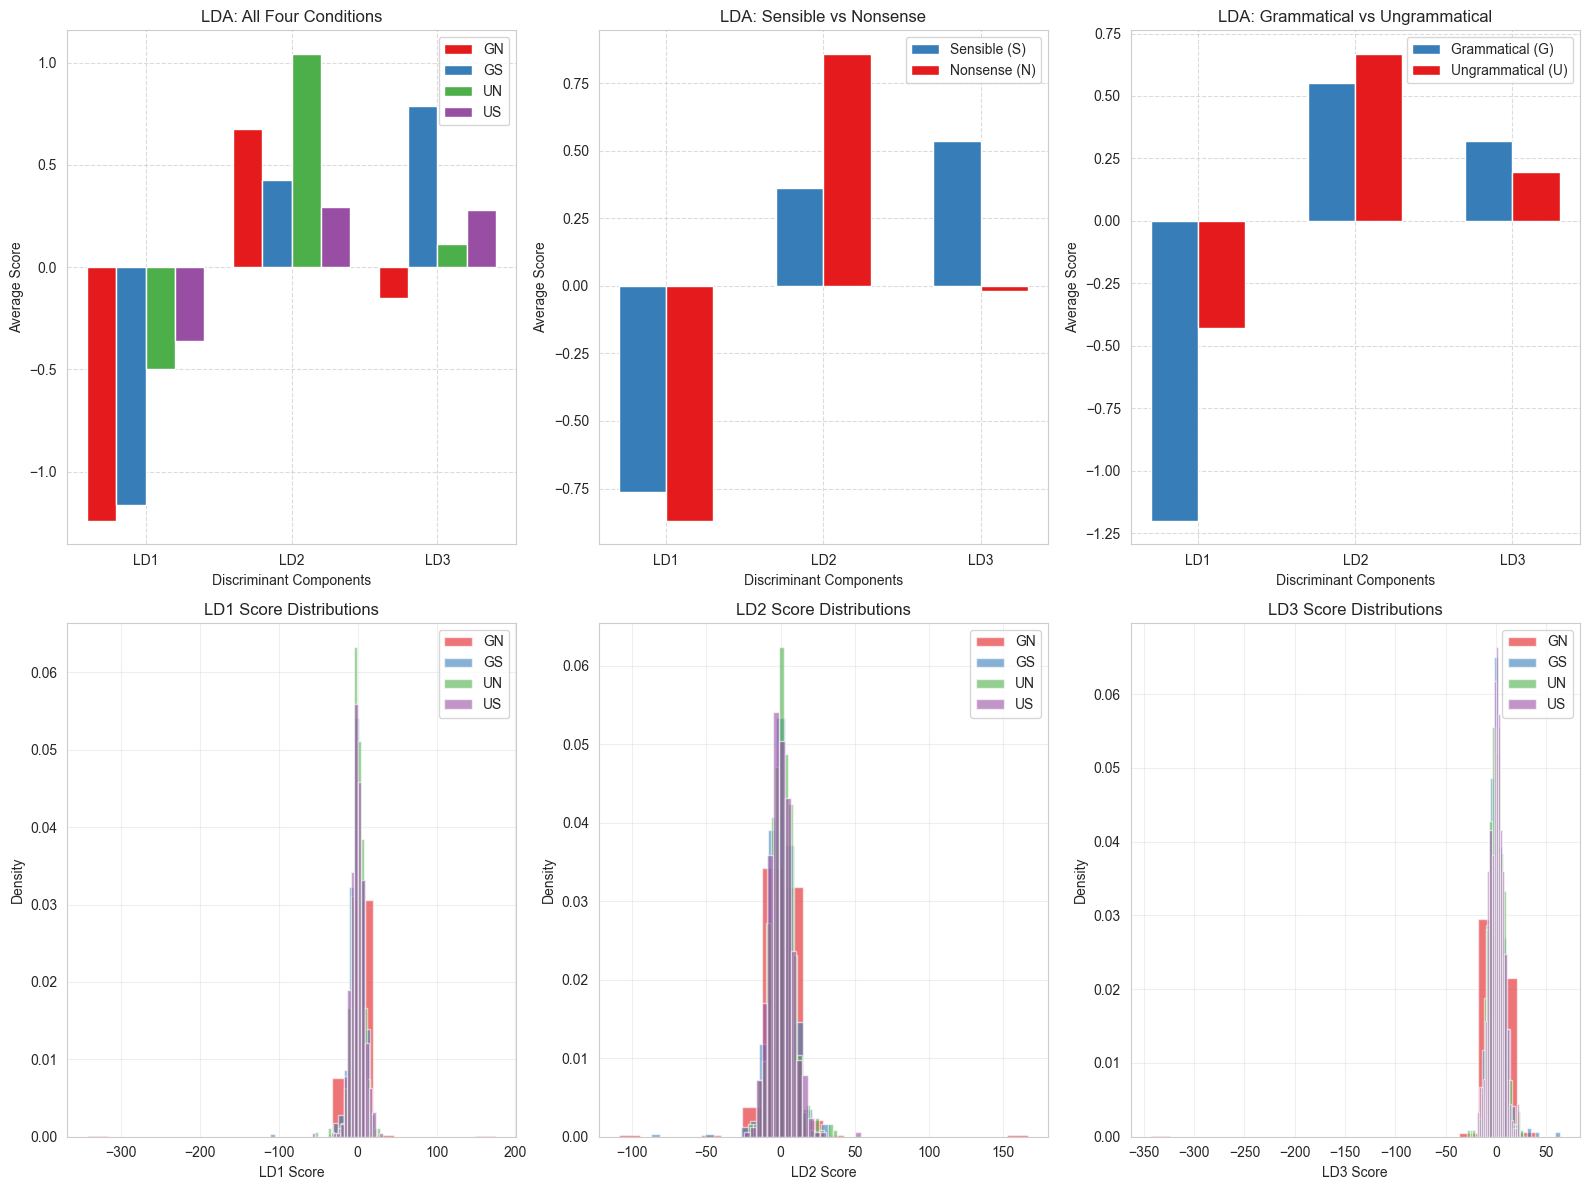


LDA Condition averages (discriminant scores):
GN: LD1=-1.2409, LD2=0.6742, LD3=-0.1507
GS: LD1=-1.1615, LD2=0.4275, LD3=0.7881
UN: LD1=-0.4983, LD2=1.0429, LD3=0.1134
US: LD1=-0.3609, LD2=0.2950, LD3=0.2807

Sensible vs Nonsense differences:
LD1: 0.1084, LD2: -0.4973, LD3: 0.5530

Grammatical vs Ungrammatical differences:
LD1: -0.7716, LD2: -0.1181, LD3: 0.1216

LDA Classification Accuracy: 0.943 (94.3%)

💾 SAVING LDA DISCRIMINANT RESULTS
-----------------------------------
✓ Saved: Data/eeg_lda_discriminant_scores.csv
✓ Shape: (1680, 6)
✓ Columns: ['participant', 'trial', 'condition', 'LD1', 'LD2', 'LD3']

Sample data:
  participant  trial condition        LD1        LD2        LD3
0         S10      1        GN  -5.589721   9.396990  -2.524706
1         S10      2        GN  -7.269823  -4.961362  10.110439
2         S10      3        GN   6.328561  -9.745631   6.512862
3         S10      4        GN -10.227650  -0.997567   1.498816
4         S10      5        GN -26.748223  10.21841

In [21]:
def plot_condition_discriminant_scores(lda_results, y_conditions):
    """
    Plot LDA discriminant scores for different conditions.
    Shows how well LDA separates the conditions.
    """
    
    print("\nPlotting LDA discriminant scores...")
    
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    unique_conditions = np.unique(y_conditions)
    
    fig = plt.figure(figsize=(16, 12))
    
    # Define colors for conditions
    cond_colors = {
        'GN': '#e41a1c',  # Grammatical Nonsense - red
        'GS': '#377eb8',  # Grammatical Sensible - blue
        'UN': '#4daf4a',  # Ungrammatical Nonsense - green
        'US': '#984ea3'   # Ungrammatical Sensible - purple
    }
    
    # Calculate means for each condition and component
    condition_means = {}
    for cond in unique_conditions:
        mask = y_conditions == cond
        condition_means[cond] = np.mean(X_lda[mask], axis=0)
    
    # Plot 1: All conditions mean scores
    plt.subplot(2, 3, 1)
    width = 0.2
    x = np.arange(n_components)
    
    for i, cond in enumerate(unique_conditions):
        plt.bar(x + i*width, condition_means[cond], width, 
                label=cond, color=cond_colors[cond])
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: All Four Conditions')
    plt.xticks(x + width*1.5, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Sensible vs Nonsense
    plt.subplot(2, 3, 2)
    s_mask = (y_conditions == 'GS') | (y_conditions == 'US')
    n_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
    
    s_avg = np.mean(X_lda[s_mask], axis=0)
    n_avg = np.mean(X_lda[n_mask], axis=0)
    
    plt.bar(x - 0.15, s_avg, width=0.3, label='Sensible (S)', color='#377eb8')
    plt.bar(x + 0.15, n_avg, width=0.3, label='Nonsense (N)', color='#e41a1c')
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: Sensible vs Nonsense')
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Grammatical vs Ungrammatical
    plt.subplot(2, 3, 3)
    g_mask = (y_conditions == 'GN') | (y_conditions == 'GS')
    u_mask = (y_conditions == 'UN') | (y_conditions == 'US')
    
    g_avg = np.mean(X_lda[g_mask], axis=0)
    u_avg = np.mean(X_lda[u_mask], axis=0)
    
    plt.bar(x - 0.15, g_avg, width=0.3, label='Grammatical (G)', color='#377eb8')
    plt.bar(x + 0.15, u_avg, width=0.3, label='Ungrammatical (U)', color='#e41a1c')
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: Grammatical vs Ungrammatical')
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plots 4-6: Individual component distributions
    for comp_idx in range(min(3, n_components)):
        plt.subplot(2, 3, 4 + comp_idx)
        
        for condition in unique_conditions:
            mask = y_conditions == condition
            scores = X_lda[mask, comp_idx]
            plt.hist(scores, alpha=0.6, label=f'{condition}', 
                   color=cond_colors[condition], bins=20, density=True)
        
        plt.xlabel(f'LD{comp_idx+1} Score')
        plt.ylabel('Density')
        plt.title(f'LD{comp_idx+1} Score Distributions')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nLDA Condition averages (discriminant scores):")
    for cond in unique_conditions:
        scores_str = ", ".join([f"LD{i+1}={condition_means[cond][i]:.4f}" 
                               for i in range(n_components)])
        print(f"{cond}: {scores_str}")
    
    # Print pairwise comparisons
    print("\nSensible vs Nonsense differences:")
    diff_str = ", ".join([f"LD{i+1}: {s_avg[i] - n_avg[i]:.4f}" 
                         for i in range(n_components)])
    print(diff_str)
    
    print("\nGrammatical vs Ungrammatical differences:")
    diff_str = ", ".join([f"LD{i+1}: {g_avg[i] - u_avg[i]:.4f}" 
                         for i in range(n_components)])
    print(diff_str)
    
    # Classification accuracy
    y_pred = lda_results['model'].predict(lda_results['scaler'].transform(X_original))
    accuracy = np.mean(y_pred == y_conditions)
    print(f"\nLDA Classification Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

def save_lda_results(lda_results, feature_matrix):
    """Save LDA discriminant results"""
    
    print(f"\n💾 SAVING LDA DISCRIMINANT RESULTS")
    print("-" * 35)
    
    # Create dataframe with discriminant components
    lda_df = pd.DataFrame({
        'participant': feature_matrix['participant'].values,
        'trial': feature_matrix['trial'].values,
        'condition': feature_matrix['condition'].values,
    })
    
    # Add discriminant components
    for i in range(lda_results['n_components']):
        lda_df[f'LD{i+1}'] = lda_results['data'][:, i]
    
    # Save to CSV
    filename = 'Data/eeg_lda_discriminant_scores.csv'
    lda_df.to_csv(filename, index=False)
    
    print(f"✓ Saved: {filename}")
    print(f"✓ Shape: {lda_df.shape}")
    print(f"✓ Columns: {list(lda_df.columns)}")
    
    # Show sample data
    print(f"\nSample data:")
    print(lda_df.head())
    
    # Show condition distribution
    print(f"\nCondition distribution:")
    print(lda_df['condition'].value_counts())
    
    return filename, lda_df

# Call the function and save results
if 'lda_results' in locals() and 'y_conditions' in locals():
    plot_condition_discriminant_scores(lda_results, y_conditions)

# Save LDA results
if 'lda_results' in locals():
    lda_output_file, final_lda_df = save_lda_results(lda_results, feature_matrix)

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class EEGLanguageAnalyzer:
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self._prepare_binary_labels()
        
    def _prepare_binary_labels(self):
        """Create binary labels for grammar and sensibility tasks"""
        self.data['grammar'] = self.data['condition'].map({
            'GS': 1, 'GN': 1, 'US': 0, 'UN': 0
        })
        self.data['sensibility'] = self.data['condition'].map({
            'GS': 1, 'US': 1, 'GN': 0, 'UN': 0
        })
        
    def preprocess_features(self, feature_cols, target='condition'):
        """Feature preprocessing pipeline with dimensionality reduction"""
        print("Feature preprocessing...")
        print("-" * 30)
        
        X = self.data[feature_cols].values
        y = self.data[target].values
        participants = self.data['participant'].values
        
        # Remove zero-variance features
        feature_var = np.var(X, axis=0)
        valid_features = feature_var > 1e-6
        X_filtered = X[:, valid_features]
        print(f"Removed {np.sum(~valid_features)} zero-variance features")
        
        # Feature selection for high-dimensional data
        if X_filtered.shape[1] > 100:
            selector = SelectKBest(f_classif, k=min(100, X_filtered.shape[1] // 2))
            X_selected = selector.fit_transform(X_filtered, y)
            print(f"Selected {X_selected.shape[1]} most informative features")
        else:
            X_selected = X_filtered
            
        # PCA for further dimensionality reduction
        if X_selected.shape[1] > 50:
            pca = PCA(n_components=0.95, random_state=42)
            X_pca = pca.fit_transform(X_selected)
            print(f"PCA: {X_pca.shape[1]} components retain 95% variance")
            self.pca_transformer = pca
        else:
            X_pca = X_selected
            self.pca_transformer = None
            
        return X_pca, y, participants
    
    def apply_lda_transformation(self, feature_cols):
        """Apply Linear Discriminant Analysis with cross-validation"""
        print("\nLinear Discriminant Analysis")
        print("-" * 35)
        
        X, y, participants = self.preprocess_features(feature_cols)
        
        # Leave-one-participant-out cross-validation
        logo = LeaveOneGroupOut()
        
        transformed_data = []
        grammar_labels = []
        sensibility_labels = []
        conditions = []
        cv_accuracies = []
        
        print(f"Cross-validation: {len(np.unique(participants))} folds")
        
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, participants)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Standardization within fold
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            try:
                lda = LinearDiscriminantAnalysis(n_components=3)
                lda.fit(X_train_scaled, y_train)
                X_test_lda = lda.transform(X_test_scaled)
                
                transformed_data.append(X_test_lda)
                
                # Get corresponding labels
                test_participants = participants[test_idx]
                test_grammar = self.data[self.data['participant'].isin(test_participants)]['grammar'].values
                test_sensibility = self.data[self.data['participant'].isin(test_participants)]['sensibility'].values
                
                grammar_labels.extend(test_grammar[:len(X_test_lda)])
                sensibility_labels.extend(test_sensibility[:len(X_test_lda)])
                conditions.extend(y_test)
                
                cv_accuracies.append(lda.score(X_test_scaled, y_test))
                
            except Exception as e:
                print(f"Warning: Fold {fold_idx} failed: {e}")
                continue
        
        # Combine cross-validation results
        X_lda = np.vstack(transformed_data)
        y_grammar = np.array(grammar_labels)
        y_sensibility = np.array(sensibility_labels)
        
        mean_accuracy = np.mean(cv_accuracies)
        print(f"Cross-validation accuracy: {mean_accuracy:.3f}")
        
        if mean_accuracy < 0.30:
            print("LDA performance insufficient, using direct classification")
            return self._direct_classification(feature_cols)
        
        # Create LDA dataset
        lda_data = pd.DataFrame({
            'LD1': X_lda[:, 0],
            'LD2': X_lda[:, 1], 
            'LD3': X_lda[:, 2],
            'grammar': y_grammar,
            'sensibility': y_sensibility
        })
        
        return lda_data, mean_accuracy
    
    def _direct_classification(self, feature_cols):
        """Direct binary classification when LDA fails"""
        print("\nDirect binary classification")
        print("-" * 40)
        
        X, _, participants = self.preprocess_features(feature_cols, target='grammar')
        
        y_grammar = self.data['grammar'].values
        y_sensibility = self.data['sensibility'].values
        
        # Feature selection for each task
        n_features = min(10, X.shape[1])
        
        selector_grammar = SelectKBest(f_classif, k=n_features)
        selector_sensibility = SelectKBest(f_classif, k=n_features)
        
        X_grammar = selector_grammar.fit_transform(X, y_grammar)
        X_sensibility = selector_sensibility.fit_transform(X, y_sensibility)
        
        # Combine features
        X_combined = np.hstack([X_grammar, X_sensibility])
        
        feature_names = [f'Feature_{i}' for i in range(X_combined.shape[1])]
        direct_data = pd.DataFrame(X_combined, columns=feature_names)
        direct_data['grammar'] = y_grammar
        direct_data['sensibility'] = y_sensibility
        
        print(f"Using {X_combined.shape[1]} selected features")
        return direct_data, 1.0
    
    def build_multitask_network(self, input_dim):
        """Build multi-task neural network architecture"""
        inputs = Input(shape=(input_dim,), name='eeg_features')
        
        # Feature extraction layers
        x = Dense(64, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Dense(32, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        # Shared representation layer
        shared = Dense(16, activation='relu', name='shared_features')(x)
        shared = Dropout(0.1)(shared)
        
        # Task-specific branches
        grammar_head = Dense(8, activation='relu')(shared)
        grammar_output = Dense(1, activation='sigmoid', name='grammar_output')(grammar_head)
        
        sensibility_head = Dense(8, activation='relu')(shared)
        sensibility_output = Dense(1, activation='sigmoid', name='sensibility_output')(sensibility_head)
        
        model = Model(inputs=inputs, 
                     outputs=[grammar_output, sensibility_output],
                     name='EEG_Language_Network')
        
        return model
    
    def train_multitask_network(self, data, feature_cols):
        """Train multi-task neural network"""
        print("\nNeural network training")
        print("-" * 35)
        
        X = data[feature_cols].values
        y_grammar = data['grammar'].values
        y_sensibility = data['sensibility'].values
        
        # Train-test split
        from sklearn.model_selection import train_test_split
        
        X_train, X_test, y_gram_train, y_gram_test, y_sens_train, y_sens_test = train_test_split(
            X, y_grammar, y_sensibility, 
            test_size=0.2, 
            random_state=42,
            stratify=y_grammar
        )
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Input dimensions: {X_train_scaled.shape[1]}")
        
        # Build and compile model
        model = self.build_multitask_network(X_train_scaled.shape[1])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss={'grammar_output': 'binary_crossentropy',
                  'sensibility_output': 'binary_crossentropy'},
            loss_weights={'grammar_output': 1.0, 'sensibility_output': 1.0},
            metrics={'grammar_output': ['accuracy'], 'sensibility_output': ['accuracy']}
        )
        
        print(f"Model parameters: {model.count_params():,}")
        
        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
        ]
        
        # Train model
        history = model.fit(
            X_train_scaled,
            {'grammar_output': y_gram_train, 'sensibility_output': y_sens_train},
            validation_data=(X_test_scaled, {'grammar_output': y_gram_test, 'sensibility_output': y_sens_test}),
            epochs=100,
            batch_size=16,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluation
        train_results = model.evaluate(X_train_scaled, 
                                     {'grammar_output': y_gram_train, 'sensibility_output': y_sens_train}, 
                                     verbose=0)
        test_results = model.evaluate(X_test_scaled, 
                                    {'grammar_output': y_gram_test, 'sensibility_output': y_sens_test}, 
                                    verbose=0)
        
        print(f"\nResults:")
        print(f"Training   - Grammar: {train_results[3]:.3f}, Sensibility: {train_results[4]:.3f}")
        print(f"Testing    - Grammar: {test_results[3]:.3f}, Sensibility: {test_results[4]:.3f}")
        
        # Analyze processing mechanisms
        self._analyze_processing_mechanisms(test_results, model, X_test_scaled, y_gram_test, y_sens_test)
            
        return model, history, scaler, (X_test_scaled, y_gram_test, y_sens_test)
    
    def _analyze_processing_mechanisms(self, test_results, model, X_test, y_gram_test, y_sens_test):
        """Analyze neural processing mechanisms for grammar and sensibility"""
        print(f"\nProcessing mechanism analysis")
        print("=" * 50)
        
        grammar_acc = test_results[3]
        sensibility_acc = test_results[4]
        
        # Get model predictions
        grammar_pred = model.predict(X_test)[0].flatten()
        sensibility_pred = model.predict(X_test)[1].flatten()
        
        # Compute correlations
        pred_correlation = np.corrcoef(grammar_pred, sensibility_pred)[0, 1]
        label_correlation = np.corrcoef(y_gram_test, y_sens_test)[0, 1]
        
        print(f"Performance metrics:")
        print(f"  Grammar accuracy: {grammar_acc:.1%}")
        print(f"  Sensibility accuracy: {sensibility_acc:.1%}")
        print(f"  Average accuracy: {(grammar_acc + sensibility_acc)/2:.1%}")
        
        print(f"\nCorrelation analysis:")
        print(f"  Prediction correlation: {pred_correlation:.3f}")
        print(f"  Label correlation: {label_correlation:.3f}")
        
        # Interpret results
        print(f"\nNeural mechanism interpretation:")
        
        if abs(pred_correlation) < 0.3:
            print("Low prediction correlation indicates independent neural pathways")
            print("→ Grammar and sensibility processed by separate mechanisms")
        elif abs(pred_correlation) > 0.7:
            print("High prediction correlation indicates shared neural pathways")
            print("→ Grammar and sensibility processed by overlapping mechanisms")
        else:
            print("Moderate correlation indicates mixed processing mechanisms")
            print("→ Combination of shared and independent neural pathways")
        
        # Task specialization
        perf_diff = abs(grammar_acc - sensibility_acc)
        if perf_diff > 0.1:
            better_task = "Grammar" if grammar_acc > sensibility_acc else "Sensibility"
            print(f"\nTask specialization detected:")
            print(f"{better_task} shows superior performance ({max(grammar_acc, sensibility_acc):.1%} vs {min(grammar_acc, sensibility_acc):.1%})")
        else:
            print(f"\nBalanced processing:")
            print("Similar performance suggests equivalent neural resource allocation")
        
        # Research conclusions
        print(f"\nResearch implications:")
        if abs(pred_correlation) < 0.4 and grammar_acc > 0.55 and sensibility_acc > 0.55:
            print("Evidence supports independent processing hypothesis")
            print("→ Grammar has intrinsic neural value beyond meaning enhancement")
            print("→ Syntactic and semantic systems operate in parallel")
        elif abs(pred_correlation) > 0.6:
            print("Evidence supports shared processing hypothesis")
            print("→ Grammar primarily serves to facilitate meaning comprehension")
            print("→ Syntactic processing is integrated with semantic processing")
        else:
            print("Evidence indicates hybrid processing model")
            print("→ Grammar serves both intrinsic and meaning-facilitation roles")
        
        return {
            'grammar_accuracy': grammar_acc,
            'sensibility_accuracy': sensibility_acc,
            'prediction_correlation': pred_correlation,
            'label_correlation': label_correlation,
            'independent_processing': abs(pred_correlation) < 0.4
        }

    def analyze_representational_structure(self, model, processed_data):
        """Analyze internal representational structure of trained network"""
        print(f"\nRepresentational structure analysis")
        print("=" * 55)
        
        # Extract shared layer representations
        from tensorflow.keras.models import Model as KerasModel
        
        representation_extractor = KerasModel(
            inputs=model.input,
            outputs=model.get_layer('shared_features').output
        )
        
        X = processed_data[['LD1', 'LD2', 'LD3']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Get shared representations
        shared_representations = representation_extractor.predict(X_scaled, verbose=0)
        
        # Analyze task-specific correlations
        grammar_labels = processed_data['grammar'].values
        sensibility_labels = processed_data['sensibility'].values
        
        grammar_corrs = []
        sensibility_corrs = []
        
        for i in range(shared_representations.shape[1]):
            gram_corr = np.corrcoef(shared_representations[:, i], grammar_labels)[0, 1]
            sens_corr = np.corrcoef(shared_representations[:, i], sensibility_labels)[0, 1]
            
            if not np.isnan(gram_corr):
                grammar_corrs.append(abs(gram_corr))
            if not np.isnan(sens_corr):
                sensibility_corrs.append(abs(sens_corr))
        
        # Calculate cross-task representational similarity
        if len(grammar_corrs) > 0 and len(sensibility_corrs) > 0:
            cross_task_similarity = np.corrcoef(grammar_corrs, sensibility_corrs)[0, 1]
            if np.isnan(cross_task_similarity):
                cross_task_similarity = 0.0
        else:
            cross_task_similarity = 0.0
        
        print(f"Shared representation analysis:")
        print(f"  Grammar feature correlation: {np.mean(grammar_corrs):.3f}")
        print(f"  Sensibility feature correlation: {np.mean(sensibility_corrs):.3f}")
        print(f"  Cross-task similarity: {cross_task_similarity:.3f}")
        
        if abs(cross_task_similarity) < 0.3:
            print(f"\nTask-specific neural features detected")
            print(f"→ Different representational patterns for grammar vs sensibility")
            print(f"→ Supports independent processing mechanisms")
        else:
            print(f"\nShared neural features detected")
            print(f"→ Similar representational patterns across tasks")
        
        return cross_task_similarity

# Utility functions
def process_eeg_data(data_path):
    """Process raw EEG data into feature matrix"""
    print("Processing EEG data...")
    
    df = pd.read_csv(data_path)
    print(f"Loaded {len(df)} EEG measurements")
    
    def parse_complex_coefficient(coeff_str):
        try:
            coeff_str = str(coeff_str).strip('()')
            coeff_str = coeff_str.replace('j)', 'j')
            
            complex_num = complex(coeff_str)
            magnitude = np.sqrt(complex_num.real**2 + complex_num.imag**2)
            phase = np.arctan2(complex_num.imag, complex_num.real)
            return magnitude, phase
            
        except Exception:
            return 0.0, 0.0
    
    # Extract magnitude and phase features
    magnitudes, phases = [], []
    for coeff in df['coeff']:
        mag, phase = parse_complex_coefficient(coeff)
        magnitudes.append(mag)
        phases.append(phase)
    
    df['magnitude'] = magnitudes
    df['phase'] = phases
    
    # Create pivot tables
    mag_pivot = df.pivot_table(
        index=['participant', 'trial', 'condition'], 
        columns=['electrode', 'frequency'], 
        values='magnitude',
        fill_value=0
    )
    
    phase_pivot = df.pivot_table(
        index=['participant', 'trial', 'condition'],
        columns=['electrode', 'frequency'], 
        values='phase',
        fill_value=0
    )
    
    # Generate column names
    mag_cols = [f'mag_{col[0]}_{col[1]:.3f}Hz' for col in mag_pivot.columns]
    phase_cols = [f'phase_{col[0]}_{col[1]:.3f}Hz' for col in phase_pivot.columns]
    
    mag_pivot.columns = mag_cols
    phase_pivot.columns = phase_cols
    
    # Combine feature matrix
    feature_matrix = pd.concat([mag_pivot, phase_pivot], axis=1)
    feature_matrix = feature_matrix.reset_index()
    
    feature_columns = [col for col in feature_matrix.columns 
                      if col not in ['participant', 'trial', 'condition']]
    
    print(f"Feature matrix: {len(feature_columns)} features")
    print(f"({len(mag_cols)} magnitude + {len(phase_cols)} phase)")
    
    return feature_matrix, feature_columns

def run_eeg_language_analysis(feature_matrix_or_path, feature_columns):
    """Execute complete EEG language processing analysis"""
    
    if isinstance(feature_matrix_or_path, pd.DataFrame):
        temp_path = 'temp_eeg_data.csv'
        feature_matrix_or_path.to_csv(temp_path, index=False)
        analyzer = EEGLanguageAnalyzer(temp_path)
    else:
        analyzer = EEGLanguageAnalyzer(feature_matrix_or_path)
    
    # Apply LDA transformation
    try:
        processed_data, lda_accuracy = analyzer.apply_lda_transformation(feature_columns)
        feature_cols = ['LD1', 'LD2', 'LD3'] if 'LD1' in processed_data.columns else [col for col in processed_data.columns if col not in ['grammar', 'sensibility']]
    except:
        print("LDA failed, using direct approach")
        processed_data, _ = analyzer._direct_classification(feature_columns)
        feature_cols = [col for col in processed_data.columns if col not in ['grammar', 'sensibility']]
    
    # Train neural network
    model, history, scaler, test_data = analyzer.train_multitask_network(processed_data, feature_cols)
    
    # Analyze representations
    cross_similarity = analyzer.analyze_representational_structure(model, processed_data)
    
    return analyzer, model, history, processed_data

# Main execution
print("Step 1: Processing EEG data")
feature_matrix, feature_columns = process_eeg_data('Data/combined_eeg_data.csv')

print("Step 2: Running language analysis")  
analyzer, model, history, processed_data = run_eeg_language_analysis(feature_matrix, feature_columns)

Step 1: Processing EEG data
Processing EEG data...
Loaded 3118080 EEG measurements
Feature matrix: 3712 features
(1856 magnitude + 1856 phase)
Step 2: Running language analysis

Linear Discriminant Analysis
-----------------------------------
Feature preprocessing...
------------------------------
Removed 0 zero-variance features
Selected 100 most informative features
PCA: 52 components retain 95% variance
Cross-validation: 14 folds
Cross-validation accuracy: 0.364

Neural network training
-----------------------------------
Training samples: 1344
Test samples: 336
Input dimensions: 3
Model parameters: 3,538
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - grammar_output_accuracy: 0.4896 - grammar_output_loss: 0.7088 - loss: 1.5195 - sensibility_output_accuracy: 0.5342 - sensibility_output_loss: 0.8108 - val_grammar_output_accuracy: 0.4643 - val_grammar_output_loss: 0.6933 - val_loss: 1.3977 - val_sensibility_output_accuracy: 0.4940 - val_sensibility_output_loss: 0.7043 - learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class EEGLanguageAnalyzer:
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self._prepare_binary_labels()
        
    def _prepare_binary_labels(self):
        """Create binary labels for grammar and sensibility tasks"""
        self.data['grammar'] = self.data['condition'].map({
            'GS': 1, 'GN': 1, 'US': 0, 'UN': 0
        })
        self.data['sensibility'] = self.data['condition'].map({
            'GS': 1, 'US': 1, 'GN': 0, 'UN': 0
        })
        
    def preprocess_features(self, feature_cols, target='condition'):
        """Feature preprocessing pipeline with dimensionality reduction"""
        print("Feature preprocessing...")
        print("-" * 30)
        
        X = self.data[feature_cols].values
        y = self.data[target].values
        participants = self.data['participant'].values
        
        # Remove zero-variance features
        feature_var = np.var(X, axis=0)
        valid_features = feature_var > 1e-6
        X_filtered = X[:, valid_features]
        print(f"Removed {np.sum(~valid_features)} zero-variance features")
        
        # Feature selection for high-dimensional data
        if X_filtered.shape[1] > 100:
            selector = SelectKBest(f_classif, k=min(100, X_filtered.shape[1] // 2))
            X_selected = selector.fit_transform(X_filtered, y)
            print(f"Selected {X_selected.shape[1]} most informative features")
        else:
            X_selected = X_filtered
            
        # PCA for further dimensionality reduction
        if X_selected.shape[1] > 50:
            pca = PCA(n_components=0.95, random_state=42)
            X_pca = pca.fit_transform(X_selected)
            print(f"PCA: {X_pca.shape[1]} components retain 95% variance")
            self.pca_transformer = pca
        else:
            X_pca = X_selected
            self.pca_transformer = None
            
        return X_pca, y, participants
    
    def apply_lda_transformation(self, feature_cols):
        """Apply Linear Discriminant Analysis with cross-validation"""
        print("\nLinear Discriminant Analysis")
        print("-" * 35)
        
        X, y, participants = self.preprocess_features(feature_cols)
        
        # Leave-one-participant-out cross-validation
        logo = LeaveOneGroupOut()
        
        transformed_data = []
        grammar_labels = []
        sensibility_labels = []
        conditions = []
        cv_accuracies = []
        
        print(f"Cross-validation: {len(np.unique(participants))} folds")
        
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, participants)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Standardization within fold
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            try:
                lda = LinearDiscriminantAnalysis(n_components=3)
                lda.fit(X_train_scaled, y_train)
                X_test_lda = lda.transform(X_test_scaled)
                
                transformed_data.append(X_test_lda)
                
                # Get corresponding labels
                test_participants = participants[test_idx]
                test_grammar = self.data[self.data['participant'].isin(test_participants)]['grammar'].values
                test_sensibility = self.data[self.data['participant'].isin(test_participants)]['sensibility'].values
                
                grammar_labels.extend(test_grammar[:len(X_test_lda)])
                sensibility_labels.extend(test_sensibility[:len(X_test_lda)])
                conditions.extend(y_test)
                
                cv_accuracies.append(lda.score(X_test_scaled, y_test))
                
            except Exception as e:
                print(f"Warning: Fold {fold_idx} failed: {e}")
                continue
        
        # Combine cross-validation results
        X_lda = np.vstack(transformed_data)
        y_grammar = np.array(grammar_labels)
        y_sensibility = np.array(sensibility_labels)
        
        mean_accuracy = np.mean(cv_accuracies)
        print(f"Cross-validation accuracy: {mean_accuracy:.3f}")
        
        if mean_accuracy < 0.30:
            print("LDA performance insufficient, using direct classification")
            return self._direct_classification(feature_cols)
        
        # Create LDA dataset
        lda_data = pd.DataFrame({
            'LD1': X_lda[:, 0],
            'LD2': X_lda[:, 1], 
            'LD3': X_lda[:, 2],
            'grammar': y_grammar,
            'sensibility': y_sensibility
        })
        
        return lda_data, mean_accuracy
    
    def _direct_classification(self, feature_cols):
        """Direct binary classification when LDA fails"""
        print("\nDirect binary classification")
        print("-" * 40)
        
        X, _, participants = self.preprocess_features(feature_cols, target='grammar')
        
        y_grammar = self.data['grammar'].values
        y_sensibility = self.data['sensibility'].values
        
        # Feature selection for each task
        n_features = min(10, X.shape[1])
        
        selector_grammar = SelectKBest(f_classif, k=n_features)
        selector_sensibility = SelectKBest(f_classif, k=n_features)
        
        X_grammar = selector_grammar.fit_transform(X, y_grammar)
        X_sensibility = selector_sensibility.fit_transform(X, y_sensibility)
        
        # Combine features
        X_combined = np.hstack([X_grammar, X_sensibility])
        
        feature_names = [f'Feature_{i}' for i in range(X_combined.shape[1])]
        direct_data = pd.DataFrame(X_combined, columns=feature_names)
        direct_data['grammar'] = y_grammar
        direct_data['sensibility'] = y_sensibility
        
        print(f"Using {X_combined.shape[1]} selected features")
        return direct_data, 1.0
    
    def build_multitask_network(self, input_dim):
        """Build multi-task neural network architecture"""
        inputs = Input(shape=(input_dim,), name='eeg_features')
        
        # Feature extraction layers
        x = Dense(64, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Dense(32, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        # Shared representation layer
        shared = Dense(16, activation='relu', name='shared_features')(x)
        shared = Dropout(0.1)(shared)
        
        # Task-specific branches
        grammar_head = Dense(8, activation='relu')(shared)
        grammar_output = Dense(1, activation='sigmoid', name='grammar_output')(grammar_head)
        
        sensibility_head = Dense(8, activation='relu')(shared)
        sensibility_output = Dense(1, activation='sigmoid', name='sensibility_output')(sensibility_head)
        
        model = Model(inputs=inputs, 
                     outputs=[grammar_output, sensibility_output],
                     name='EEG_Language_Network')
        
        return model
    
    def train_multitask_network(self, data, feature_cols):
        """Train multi-task neural network"""
        print("\nNeural network training")
        print("-" * 35)
        
        X = data[feature_cols].values
        y_grammar = data['grammar'].values
        y_sensibility = data['sensibility'].values
        
        # Train-test split
        from sklearn.model_selection import train_test_split
        
        X_train, X_test, y_gram_train, y_gram_test, y_sens_train, y_sens_test = train_test_split(
            X, y_grammar, y_sensibility, 
            test_size=0.2, 
            random_state=42,
            stratify=y_grammar
        )
        
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Input dimensions: {X_train_scaled.shape[1]}")
        
        # Build and compile model
        model = self.build_multitask_network(X_train_scaled.shape[1])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss={'grammar_output': 'binary_crossentropy',
                  'sensibility_output': 'binary_crossentropy'},
            loss_weights={'grammar_output': 1.0, 'sensibility_output': 1.0},
            metrics={'grammar_output': ['accuracy'], 'sensibility_output': ['accuracy']}
        )
        
        print(f"Model parameters: {model.count_params():,}")
        
        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
        ]
        
        # Train model
        history = model.fit(
            X_train_scaled,
            {'grammar_output': y_gram_train, 'sensibility_output': y_sens_train},
            validation_data=(X_test_scaled, {'grammar_output': y_gram_test, 'sensibility_output': y_sens_test}),
            epochs=100,
            batch_size=16,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluation
        train_results = model.evaluate(X_train_scaled, 
                                     {'grammar_output': y_gram_train, 'sensibility_output': y_sens_train}, 
                                     verbose=0)
        test_results = model.evaluate(X_test_scaled, 
                                    {'grammar_output': y_gram_test, 'sensibility_output': y_sens_test}, 
                                    verbose=0)
        
        print(f"\nResults:")
        print(f"Training   - Grammar: {train_results[3]:.3f}, Sensibility: {train_results[4]:.3f}")
        print(f"Testing    - Grammar: {test_results[3]:.3f}, Sensibility: {test_results[4]:.3f}")
        
        # Analyze processing mechanisms
        self._analyze_processing_mechanisms(test_results, model, X_test_scaled, y_gram_test, y_sens_test)
            
        return model, history, scaler, (X_test_scaled, y_gram_test, y_sens_test)
    
    def _analyze_processing_mechanisms(self, test_results, model, X_test, y_gram_test, y_sens_test):
        """Analyze neural processing mechanisms for grammar and sensibility"""
        print(f"\nProcessing mechanism analysis")
        print("=" * 50)
        
        grammar_acc = test_results[3]
        sensibility_acc = test_results[4]
        
        # Get model predictions
        grammar_pred = model.predict(X_test)[0].flatten()
        sensibility_pred = model.predict(X_test)[1].flatten()
        
        # Compute correlations
        pred_correlation = np.corrcoef(grammar_pred, sensibility_pred)[0, 1]
        label_correlation = np.corrcoef(y_gram_test, y_sens_test)[0, 1]
        
        print(f"Performance metrics:")
        print(f"  Grammar accuracy: {grammar_acc:.1%}")
        print(f"  Sensibility accuracy: {sensibility_acc:.1%}")
        print(f"  Average accuracy: {(grammar_acc + sensibility_acc)/2:.1%}")
        
        print(f"\nCorrelation analysis:")
        print(f"  Prediction correlation: {pred_correlation:.3f}")
        print(f"  Label correlation: {label_correlation:.3f}")
        
        # Interpret results
        print(f"\nNeural mechanism interpretation:")
        
        if abs(pred_correlation) < 0.3:
            print("Low prediction correlation indicates independent neural pathways")
            print("→ Grammar and sensibility processed by separate mechanisms")
        elif abs(pred_correlation) > 0.7:
            print("High prediction correlation indicates shared neural pathways")
            print("→ Grammar and sensibility processed by overlapping mechanisms")
        else:
            print("Moderate correlation indicates mixed processing mechanisms")
            print("→ Combination of shared and independent neural pathways")
        
        # Task specialization
        perf_diff = abs(grammar_acc - sensibility_acc)
        if perf_diff > 0.1:
            better_task = "Grammar" if grammar_acc > sensibility_acc else "Sensibility"
            print(f"\nTask specialization detected:")
            print(f"{better_task} shows superior performance ({max(grammar_acc, sensibility_acc):.1%} vs {min(grammar_acc, sensibility_acc):.1%})")
        else:
            print(f"\nBalanced processing:")
            print("Similar performance suggests equivalent neural resource allocation")
        
        # Research conclusions
        print(f"\nResearch implications:")
        if abs(pred_correlation) < 0.4 and grammar_acc > 0.55 and sensibility_acc > 0.55:
            print("Evidence supports independent processing hypothesis")
            print("→ Grammar has intrinsic neural value beyond meaning enhancement")
            print("→ Syntactic and semantic systems operate in parallel")
        elif abs(pred_correlation) > 0.6:
            print("Evidence supports shared processing hypothesis")
            print("→ Grammar primarily serves to facilitate meaning comprehension")
            print("→ Syntactic processing is integrated with semantic processing")
        else:
            print("Evidence indicates hybrid processing model")
            print("→ Grammar serves both intrinsic and meaning-facilitation roles")
        
        return {
            'grammar_accuracy': grammar_acc,
            'sensibility_accuracy': sensibility_acc,
            'prediction_correlation': pred_correlation,
            'label_correlation': label_correlation,
            'independent_processing': abs(pred_correlation) < 0.4
        }

    def analyze_representational_structure(self, model, processed_data):
        """Analyze internal representational structure of trained network"""
        print(f"\nRepresentational structure analysis")
        print("=" * 55)
        
        # Extract shared layer representations
        from tensorflow.keras.models import Model as KerasModel
        
        representation_extractor = KerasModel(
            inputs=model.input,
            outputs=model.get_layer('shared_features').output
        )
        
        X = processed_data[['LD1', 'LD2', 'LD3']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Get shared representations
        shared_representations = representation_extractor.predict(X_scaled, verbose=0)
        
        # Analyze task-specific correlations
        grammar_labels = processed_data['grammar'].values
        sensibility_labels = processed_data['sensibility'].values
        
        grammar_corrs = []
        sensibility_corrs = []
        
        for i in range(shared_representations.shape[1]):
            gram_corr = np.corrcoef(shared_representations[:, i], grammar_labels)[0, 1]
            sens_corr = np.corrcoef(shared_representations[:, i], sensibility_labels)[0, 1]
            
            if not np.isnan(gram_corr):
                grammar_corrs.append(abs(gram_corr))
            if not np.isnan(sens_corr):
                sensibility_corrs.append(abs(sens_corr))
        
        # Calculate cross-task representational similarity
        if len(grammar_corrs) > 0 and len(sensibility_corrs) > 0:
            cross_task_similarity = np.corrcoef(grammar_corrs, sensibility_corrs)[0, 1]
            if np.isnan(cross_task_similarity):
                cross_task_similarity = 0.0
        else:
            cross_task_similarity = 0.0
        
        print(f"Shared representation analysis:")
        print(f"  Grammar feature correlation: {np.mean(grammar_corrs):.3f}")
        print(f"  Sensibility feature correlation: {np.mean(sensibility_corrs):.3f}")
        print(f"  Cross-task similarity: {cross_task_similarity:.3f}")
        
        if abs(cross_task_similarity) < 0.3:
            print(f"\nTask-specific neural features detected")
            print(f"→ Different representational patterns for grammar vs sensibility")
            print(f"→ Supports independent processing mechanisms")
        else:
            print(f"\nShared neural features detected")
            print(f"→ Similar representational patterns across tasks")
        
        return cross_task_similarity

# Utility functions
def process_eeg_data(data_path):
    """Process raw EEG data into feature matrix"""
    print("Processing EEG data...")
    
    df = pd.read_csv(data_path)
    print(f"Loaded {len(df)} EEG measurements")
    
    def parse_complex_coefficient(coeff_str):
        try:
            coeff_str = str(coeff_str).strip('()')
            coeff_str = coeff_str.replace('j)', 'j')
            
            complex_num = complex(coeff_str)
            magnitude = np.sqrt(complex_num.real**2 + complex_num.imag**2)
            phase = np.arctan2(complex_num.imag, complex_num.real)
            return magnitude, phase
            
        except Exception:
            return 0.0, 0.0
    
    # Extract magnitude and phase features
    magnitudes, phases = [], []
    for coeff in df['coeff']:
        mag, phase = parse_complex_coefficient(coeff)
        magnitudes.append(mag)
        phases.append(phase)
    
    df['magnitude'] = magnitudes
    df['phase'] = phases
    
    # Create pivot tables
    mag_pivot = df.pivot_table(
        index=['participant', 'trial', 'condition'], 
        columns=['electrode', 'frequency'], 
        values='magnitude',
        fill_value=0
    )
    
    phase_pivot = df.pivot_table(
        index=['participant', 'trial', 'condition'],
        columns=['electrode', 'frequency'], 
        values='phase',
        fill_value=0
    )
    
    # Generate column names
    mag_cols = [f'mag_{col[0]}_{col[1]:.3f}Hz' for col in mag_pivot.columns]
    phase_cols = [f'phase_{col[0]}_{col[1]:.3f}Hz' for col in phase_pivot.columns]
    
    mag_pivot.columns = mag_cols
    phase_pivot.columns = phase_cols
    
    # Combine feature matrix
    feature_matrix = pd.concat([mag_pivot, phase_pivot], axis=1)
    feature_matrix = feature_matrix.reset_index()
    
    feature_columns = [col for col in feature_matrix.columns 
                      if col not in ['participant', 'trial', 'condition']]
    
    print(f"Feature matrix: {len(feature_columns)} features")
    print(f"({len(mag_cols)} magnitude + {len(phase_cols)} phase)")
    
    return feature_matrix, feature_columns

def run_eeg_language_analysis(feature_matrix_or_path, feature_columns):
    """Execute complete EEG language processing analysis"""
    
    if isinstance(feature_matrix_or_path, pd.DataFrame):
        temp_path = 'temp_eeg_data.csv'
        feature_matrix_or_path.to_csv(temp_path, index=False)
        analyzer = EEGLanguageAnalyzer(temp_path)
    else:
        analyzer = EEGLanguageAnalyzer(feature_matrix_or_path)
    
    # Apply LDA transformation
    try:
        processed_data, lda_accuracy = analyzer.apply_lda_transformation(feature_columns)
        feature_cols = ['LD1', 'LD2', 'LD3'] if 'LD1' in processed_data.columns else [col for col in processed_data.columns if col not in ['grammar', 'sensibility']]
    except:
        print("LDA failed, using direct approach")
        processed_data, _ = analyzer._direct_classification(feature_columns)
        feature_cols = [col for col in processed_data.columns if col not in ['grammar', 'sensibility']]
    
    # Train neural network
    model, history, scaler, test_data = analyzer.train_multitask_network(processed_data, feature_cols)
    
    # Analyze representations
    cross_similarity = analyzer.analyze_representational_structure(model, processed_data)
    
    return analyzer, model, history, processed_data

# Main execution
print("Step 1: Processing EEG data")
feature_matrix, feature_columns = process_eeg_data('Data/combined_eeg_data.csv')

print("Step 2: Running language analysis")  
analyzer, model, history, processed_data = run_eeg_language_analysis(feature_matrix, feature_columns)

In [ ]:
analyzer, results = run_domain_specific_analysis('Data/combined_eeg_data.csv')

Research Questions Setup:
- Grammar Task: Does brain distinguish grammatical vs ungrammatical?
- Sensibility Task: Does brain distinguish sensible vs nonsensical?
- Interaction: How do grammar and sensibility interact?
Loaded 3118080 EEG measurements

🔧 ADVANCED FEATURE EXTRACTION
----------------------------------------
✓ Extracted magnitude, phase, and power features

🏁 COMPARING ALL MODEL ARCHITECTURES

==================== CNN ====================

🎯 TRAINING CNN MODEL
----------------------------------------

🧠 SPATIOTEMPORAL FEATURE ENGINEERING
---------------------------------------------
✓ Created spatiotemporal dataset:
  - Shape: (1680, 5568)
  - Trials: 1680
  - Participants: 14

Fold 1: Testing participant S10
Results - Grammar: 0.492, Sensibility: 0.217, Interaction: 0.500

Fold 2: Testing participant S11
Results - Grammar: 0.500, Sensibility: 0.225, Interaction: 0.500

Fold 3: Testing participant S12
Results - Grammar: 0.500, Sensibility: 0.308, Interaction: 0.500

Fold 4

KeyboardInterrupt: 